In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')   
    RUNNING_IN_COLAB = True
    
except:
    print("Not in Colab")
    RUNNING_IN_COLAB = False
    
if RUNNING_IN_COLAB:
    print("Running in Colab")
    #pull git repo and install requirements
    !git clone https://github.com/tmengel/Deep-Learning.git
    %cd Deep-Learning/finalProject
    %pip install uproot
    %pip install pandas

import pulsenet as pn
import pandas as pd  
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import pickle as pkl
import numpy as np
from sklearn.metrics import roc_curve

Mounted at /content/drive
Running in Colab
Cloning into 'Deep-Learning'...
remote: Enumerating objects: 98043, done.
remote: Counting objects: 100% (499/499), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 98043 (delta 254), reused 483 (delta 238), pack-reused 97544
Receiving objects: 100% (98043/98043), 145.44 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (255/255), done.
Updating files: 100% (97799/97799), done.
/content/Deep-Learning/finalProject
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.4/331.4 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.8/610.8 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 82.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
filename = "ysoTracesWithPileup.root"
if RUNNING_IN_COLAB:
    filename = "/content/drive/MyDrive/DeepLearningFinalProject/ysoTracesWithPileup.root"

def GetData(filename, pileup_split=0.5, phase_min=0.1, phase_max=20, amplitude_min=0.5, amplitude_max=1.5):
    x_trace, y_trace, y_phase, y_amp = pn.CreateData(filename, pileup_split=pileup_split, phase_min=phase_min, phase_max=phase_max, amplitude_min=amplitude_min, amplitude_max=amplitude_max)
    y_pileup = pn.EncodePileup(y_phase)
    return x_trace, y_trace, y_phase, y_amp, y_pileup

def GetResults(model, phaseMin,phaseMax, filename):
    x_trace, y_trace, y_phase, y_amp, y_pileup = GetData(filename=filename, pileup_split=0.5, phase_min=phaseMin, phase_max=phaseMax, amplitude_min=0.5, amplitude_max=1.5)
    pred_trace, pred_phase, pred_amp, pred_pileup = model.predict(x_trace)
    loss, traceloss, phaseloss,amploss, pileuploss, traceacc, phaseacc, ampacc, pileupacc = model.evaluate(x_trace, [y_trace, y_phase, y_amp, y_pileup])
    n_samples = x_trace.shape[0]
    # separate out the traces
    pred_trace1 = pred_trace[:,0,:].reshape(-1, 300)
    pred_trace2 = pred_trace[:,1,:].reshape(-1, 300)
    y_trace1 = y_trace[:,0,:].reshape(-1, 300)
    y_trace2 = y_trace[:,1,:].reshape(-1, 300)
    x_trace = x_trace.reshape(-1, 300)
    
    # calculate residuals
    res_trace1 = pred_trace1 - y_trace1
    res_trace2 = pred_trace2 - y_trace2
    res_trace_total = pred_trace - y_trace
    res_phase = pred_phase - y_phase
    res_amp = pred_amp - y_amp
    
    average_res_trace1 = np.mean(res_trace1, axis=0)
    average_res_trace2 = np.mean(res_trace2, axis=0)
    std_res_trace1 = np.std(res_trace1, axis=0)
    std_res_trace2 = np.std(res_trace2, axis=0)
    
    fpr, tpr, thresholds = roc_curve(y_pileup, pred_pileup)    
    result = {
            "loss": loss,
            "trace_loss": traceloss,
            "phase_loss": phaseloss,
            "amp_loss": amploss,
            "pileup_loss": pileuploss,
            "trace_acc": traceacc,
            "phase_acc": phaseacc,
            "amp_acc": ampacc,
            "pileup_acc": pileupacc,
            "n_samples": n_samples,
            "x_trace": x_trace,
            "y_trace": y_trace,
            "y_phase": y_phase,
            "y_amp": y_amp,
            "y_pileup": y_pileup,
            "pred_trace": pred_trace,
            "pred_phase": pred_phase,
            "pred_amp": pred_amp,
            "pred_pileup": pred_pileup,
            "res_trace1": res_trace1,
            "res_trace2": res_trace2,
            "res_trace_total": res_trace_total,
            "res_phase": res_phase,
            "res_amp": res_amp,
            "average_res_trace1": average_res_trace1,
            "average_res_trace2": average_res_trace2,
            "std_res_trace1": std_res_trace1,
            "std_res_trace2": std_res_trace2,
            "fpr": fpr, "tpr": tpr, "thresholds": thresholds}
    
    return result
    

In [8]:
input = layers.Input(shape=(1, 300))  # Returns a placeholder tensor
classifer_feature_vec = pn.TraceClassifierBase(name = "classifier_base")(input)
classifier_output = pn.TraceClassifierHead(name = "classifier")(classifer_feature_vec)
phase_output = pn.TracePhaseRegressor(name="phase")(input)
amplitude_output = pn.TraceAmplitudeRegressor(name ="amplitude")(input)
discriminator_feature_vec = pn.TraceDiscriminatorBase(name = "discriminator_base")(input)
trace_output = pn.TraceDiscriminatorHead(name = "discriminator")(discriminator_feature_vec)


model = models.Model(inputs=input, outputs=[trace_output, phase_output, amplitude_output, classifier_output])
model.compile(optimizer='adam', loss=["mse", "mse", "mse", "bce"], metrics='accuracy')
model.build(input_shape=(None, 1, 300))
model_names = [model.layers[i].name for i in range(len(model.layers))]
model.layers[model_names.index("discriminator_base")].load_weights('weights/individual_discriminator_base_weights.h5')
model.layers[model_names.index("discriminator")].load_weights('weights/individual_discriminator_head_weights.h5')
model.layers[model_names.index("classifier_base")].load_weights('weights/individual_classifier_base_weights.h5')
model.layers[model_names.index("classifier")].load_weights('weights/individual_classifier_head_weights.h5')
model.layers[model_names.index("phase")].load_weights('weights/individual_phase_weights.h5')
model.layers[model_names.index("amplitude")].load_weights('weights/individual_amplitude_weights.h5')
model.save('models/TraceNet.h5')

!cp -rf models/TraceNet.h5 /content/drive/MyDrive/DeepLearningFinalProject/

In [9]:
def GetResult():
  phase_shift_bins = [0.1, 5.0, 10.0, 20.0] # 0 , 10, 20, 40 ns
  results = {}
  results[f'phase_shift_{int(phase_shift_bins[0]*2)}to{int(phase_shift_bins[-1]*2)}ns'] = GetResults(model, phaseMin=phase_shift_bins[0], phaseMax=phase_shift_bins[-1], filename=filename)
  for i in range(len(phase_shift_bins)-1):
      print(f'phase_shift_{int(phase_shift_bins[i]*2)}to{int(phase_shift_bins[i+1]*2)}ns')
      results[f'phase_shift_{int(phase_shift_bins[i]*2)}to{int(phase_shift_bins[i+1]*2)}ns'] = GetResults(model, phaseMin=phase_shift_bins[i], phaseMax=phase_shift_bins[i+1], filename=filename)

  with open('/content/drive/MyDrive/DeepLearningFinalProject/results.pickle', 'wb') as handle:
      pkl.dump(results, handle, protocol=pkl.HIGHEST_PROTOCOL)
    

In [100]:
import matplotlib.pyplot as plt
params = {'axes.labelsize': 24,
                'axes.linewidth' : 1.5,
                'font.size': 24,
                 'font.family': 'stixgeneral',
            'mathtext.fontset': 'stix',
                'legend.fontsize': 22,
                'xtick.labelsize': 22,
                'ytick.labelsize': 22,
                'text.usetex': False,
                'lines.linewidth': 2,
                'lines.linestyle': '-',
                'lines.markersize' : 6,
                'lines.markeredgewidth' : 1,
                'xtick.major.size' : 5,
                'xtick.minor.size' : 3,
                'xtick.major.width' : 2,
                'xtick.minor.width' : 1,
                'xtick.direction' : 'in',
                'ytick.major.size' : 5,
                'ytick.minor.size' : 3,
                'ytick.major.width' : 2,
                'ytick.minor.width' : 1,
                'ytick.direction' : 'in',
                'xtick.minor.visible' : True,
                'ytick.minor.visible' : True,
                'savefig.transparent': True,
                'errorbar.capsize': 1.5,
                }
plt.rcParams.update(params)

In [5]:
with open('/content/drive/MyDrive/DeepLearningFinalProject/results.pickle', 'rb') as f:
    results = pkl.load(f)  

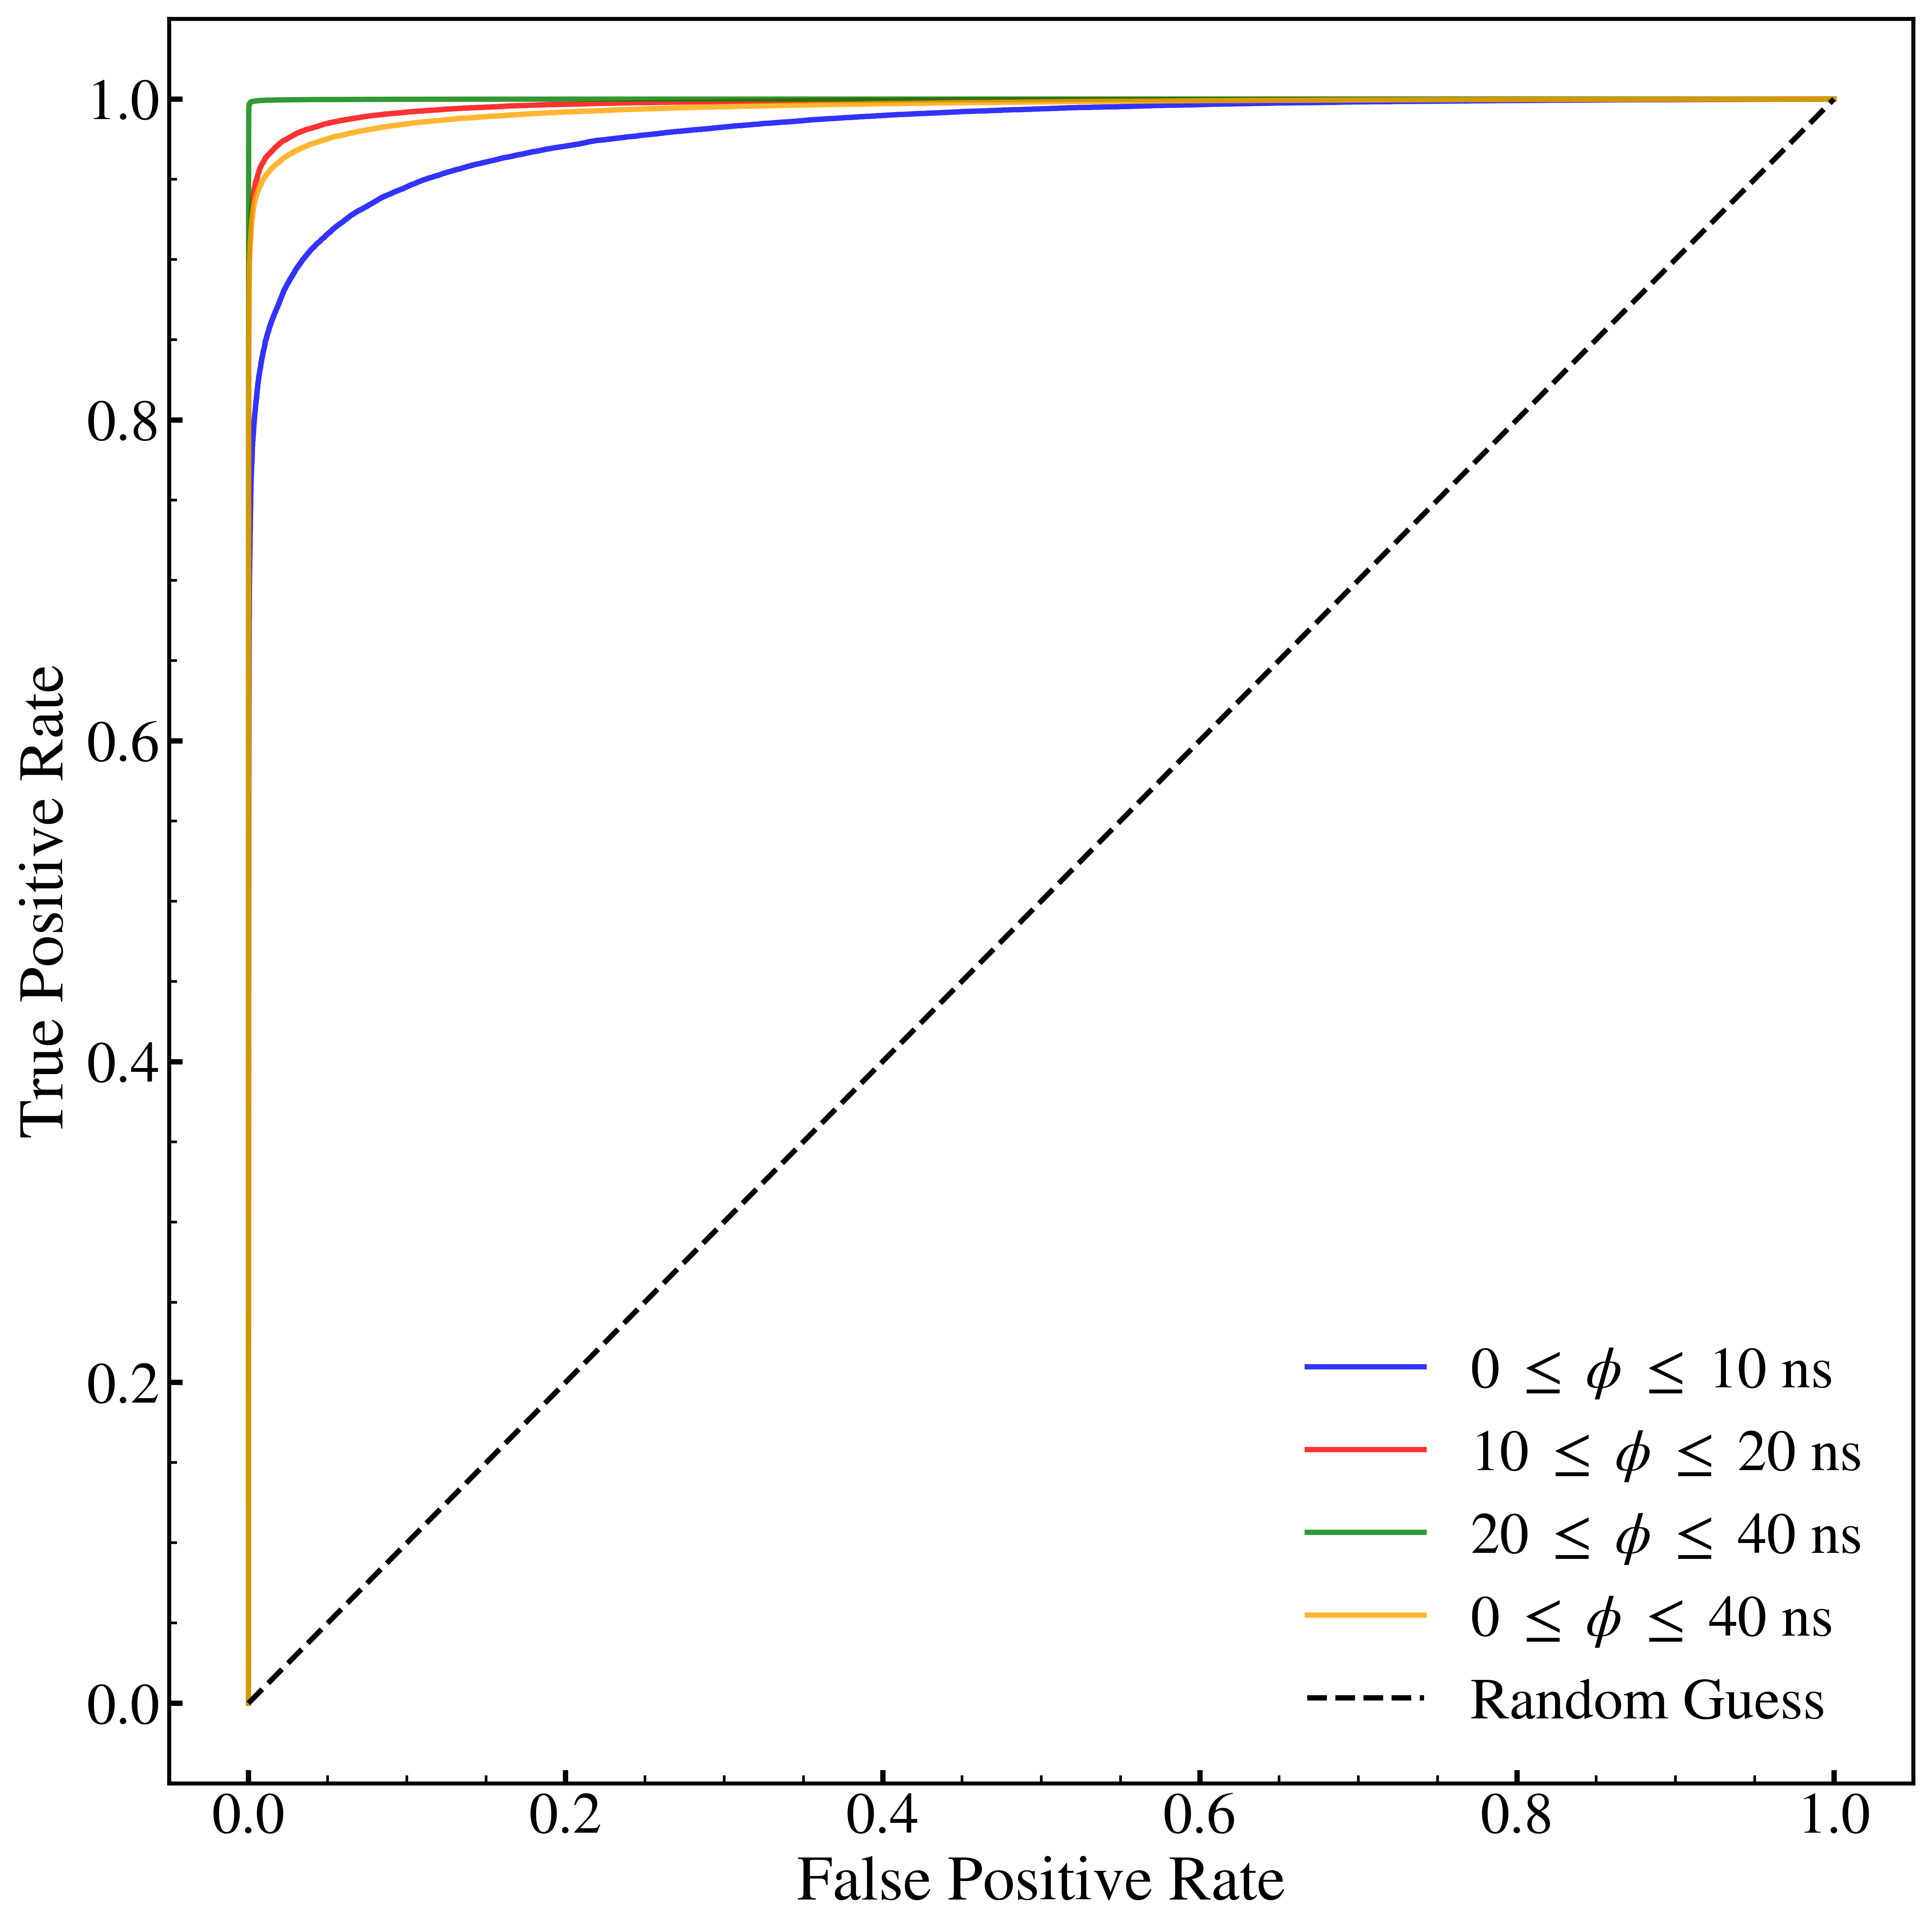

In [101]:
fig = plt.figure(figsize=(10, 10), dpi=600,constrained_layout=True)
ax = plt.subplot(111)
ax.plot(results['phase_shift_0to10ns']['fpr'], results['phase_shift_0to10ns']['tpr'], label=r'0 $\leq$ $\phi$ $\leq$ 10 ns', color='blue',alpha=0.8)
ax.plot(results['phase_shift_10to20ns']['fpr'], results['phase_shift_10to20ns']['tpr'], label=r'10 $\leq$ $\phi$ $\leq$ 20 ns', color='red',alpha=0.8)
ax.plot(results['phase_shift_20to40ns']['fpr'], results['phase_shift_20to40ns']['tpr'], label=r'20 $\leq$ $\phi$ $\leq$ 40 ns', color='green',alpha=0.8)
ax.plot(results['phase_shift_0to40ns']['fpr'], results['phase_shift_0to40ns']['tpr'], label=r'0 $\leq$ $\phi$ $\leq$ 40 ns', color='orange',alpha=0.8)
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='best', frameon=False)
plt.show()
fig.savefig('/content/drive/MyDrive/DeepLearningFinalProject/ROC.png', bbox_inches='tight')

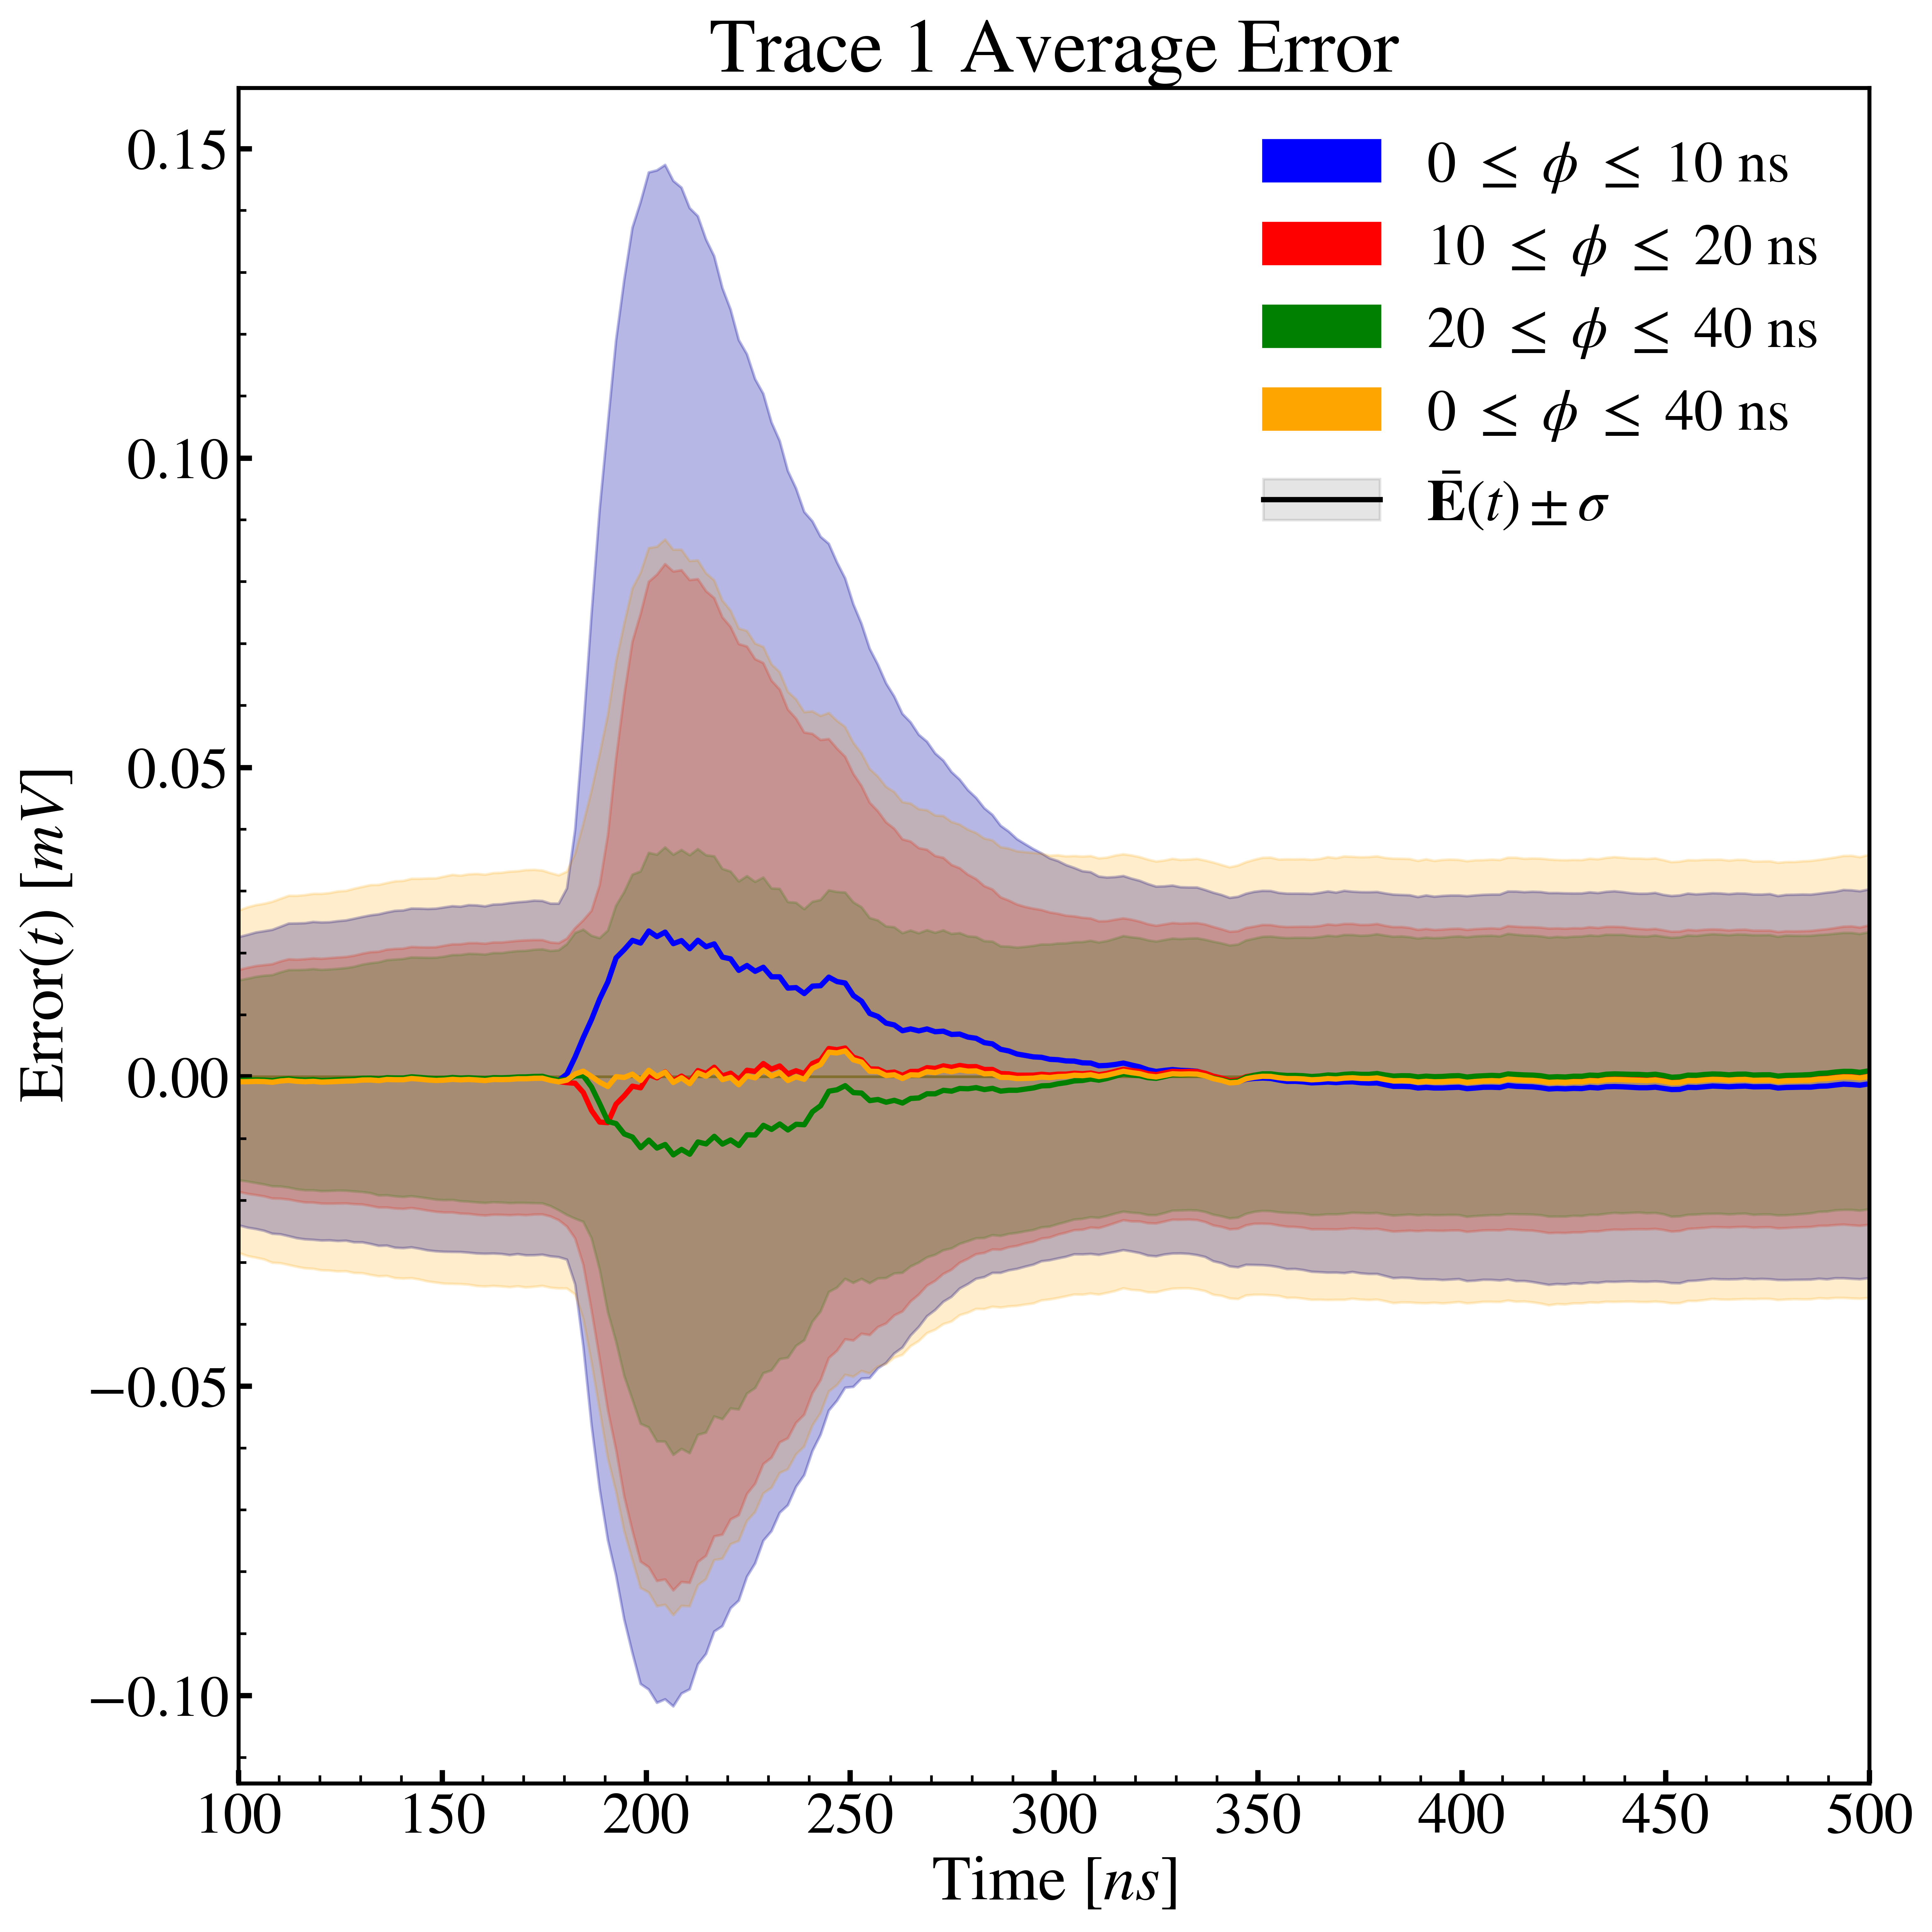

In [102]:
fig = plt.figure(figsize=(10, 10), dpi=600, constrained_layout=True)
ax = plt.subplot(111)
t = np.linspace(0,600,300)
ax.plot(t,results['phase_shift_0to10ns']['average_res_trace1'], label=r'0 $\leq$ $\phi$ $\leq$ 10 ns', color='blue')
ax.plot(t,results['phase_shift_10to20ns']['average_res_trace1'], label=r'10 $\leq$ $\phi$ $\leq$ 20 ns', color='red')
ax.plot(t,results['phase_shift_20to40ns']['average_res_trace1'], label=r'20 $\leq$ $\phi$ $\leq$ 40 ns', color='green')
ax.plot(t,results['phase_shift_0to40ns']['average_res_trace1'], label=r'0 $\leq$ $\phi$ $\leq$ 40 ns', color='orange')

ax.fill_between(t, results['phase_shift_0to10ns']['average_res_trace1'] + results['phase_shift_0to10ns']['std_res_trace1'],
                results['phase_shift_0to10ns']['average_res_trace1'] - results['phase_shift_0to10ns']['std_res_trace1'],
                color='blue', alpha=0.2, interpolate=True)

ax.fill_between(t, results['phase_shift_10to20ns']['average_res_trace1'] - results['phase_shift_10to20ns']['std_res_trace1'],
                where=results['phase_shift_10to20ns']['average_res_trace1'] - results['phase_shift_10to20ns']['std_res_trace1'] >= results['phase_shift_0to10ns']['average_res_trace1'] - results['phase_shift_0to10ns']['std_res_trace1'],
                color='red', alpha=0.2, interpolate=True)
ax.fill_between(t, results['phase_shift_10to20ns']['average_res_trace1'] + results['phase_shift_10to20ns']['std_res_trace1'],
                where=results['phase_shift_10to20ns']['average_res_trace1'] + results['phase_shift_10to20ns']['std_res_trace1'] <= results['phase_shift_0to10ns']['average_res_trace1'] + results['phase_shift_0to10ns']['std_res_trace1'],
                color='red', alpha=0.2, interpolate=True)

ax.fill_between(t, results['phase_shift_20to40ns']['average_res_trace1'] - results['phase_shift_20to40ns']['std_res_trace1'],
                where=results['phase_shift_20to40ns']['average_res_trace1'] - results['phase_shift_20to40ns']['std_res_trace1'] >= results['phase_shift_0to10ns']['average_res_trace1'] - results['phase_shift_0to10ns']['std_res_trace1'],
                color='green', alpha=0.2, interpolate=True)
ax.fill_between(t, results['phase_shift_20to40ns']['average_res_trace1'] + results['phase_shift_20to40ns']['std_res_trace1'],
                where=results['phase_shift_20to40ns']['average_res_trace1'] + results['phase_shift_20to40ns']['std_res_trace1'] <= results['phase_shift_0to10ns']['average_res_trace1'] + results['phase_shift_0to10ns']['std_res_trace1'],
                color='green', alpha=0.2, interpolate=True)
                
ax.fill_between(t, results['phase_shift_0to40ns']['average_res_trace1'] - results['phase_shift_0to40ns']['std_res_trace1'],
                results['phase_shift_0to40ns']['average_res_trace1'] + results['phase_shift_0to40ns']['std_res_trace1'],
                color='orange', alpha=0.2, interpolate=True)

ax.set_xlabel(r'Time $[ns]$')
ax.set_ylabel(r'$\mathrm{Error}(t)$ $[mV]$')
ax.set_xlim(100,500)

import matplotlib.patches as mpatches
ax.legend(loc='best',frameon=False,
          handles=[mpatches.Patch(color='blue'), mpatches.Patch(color='red'), mpatches.Patch(color='green'),mpatches.Patch(color='orange'),
                   (ax.plot([],[],linestyle="-", color='black')[0],
                    ax.fill_between(t, results['phase_shift_0to10ns']['average_res_trace1'] + results['phase_shift_0to10ns']['std_res_trace1'],
                                    results['phase_shift_0to10ns']['average_res_trace1'] - results['phase_shift_0to10ns']['std_res_trace1'],
                                    color='black', alpha=0.1, interpolate=True)),
                    ],
          labels=[r'0 $\leq$ $\phi$ $\leq$ 10 ns', r'10 $\leq$ $\phi$ $\leq$ 20 ns', r'20 $\leq$ $\phi$ $\leq$ 40 ns', r'0 $\leq$ $\phi$ $\leq$ 40 ns',r'$\bar{\mathrm{\mathbf{E}}}(t) \pm \sigma$'])
ax.set_title("Trace 1 Average Error")
plt.show()
fig.savefig('/content/drive/MyDrive/DeepLearningFinalProject/Trace1Res.png', bbox_inches='tight')

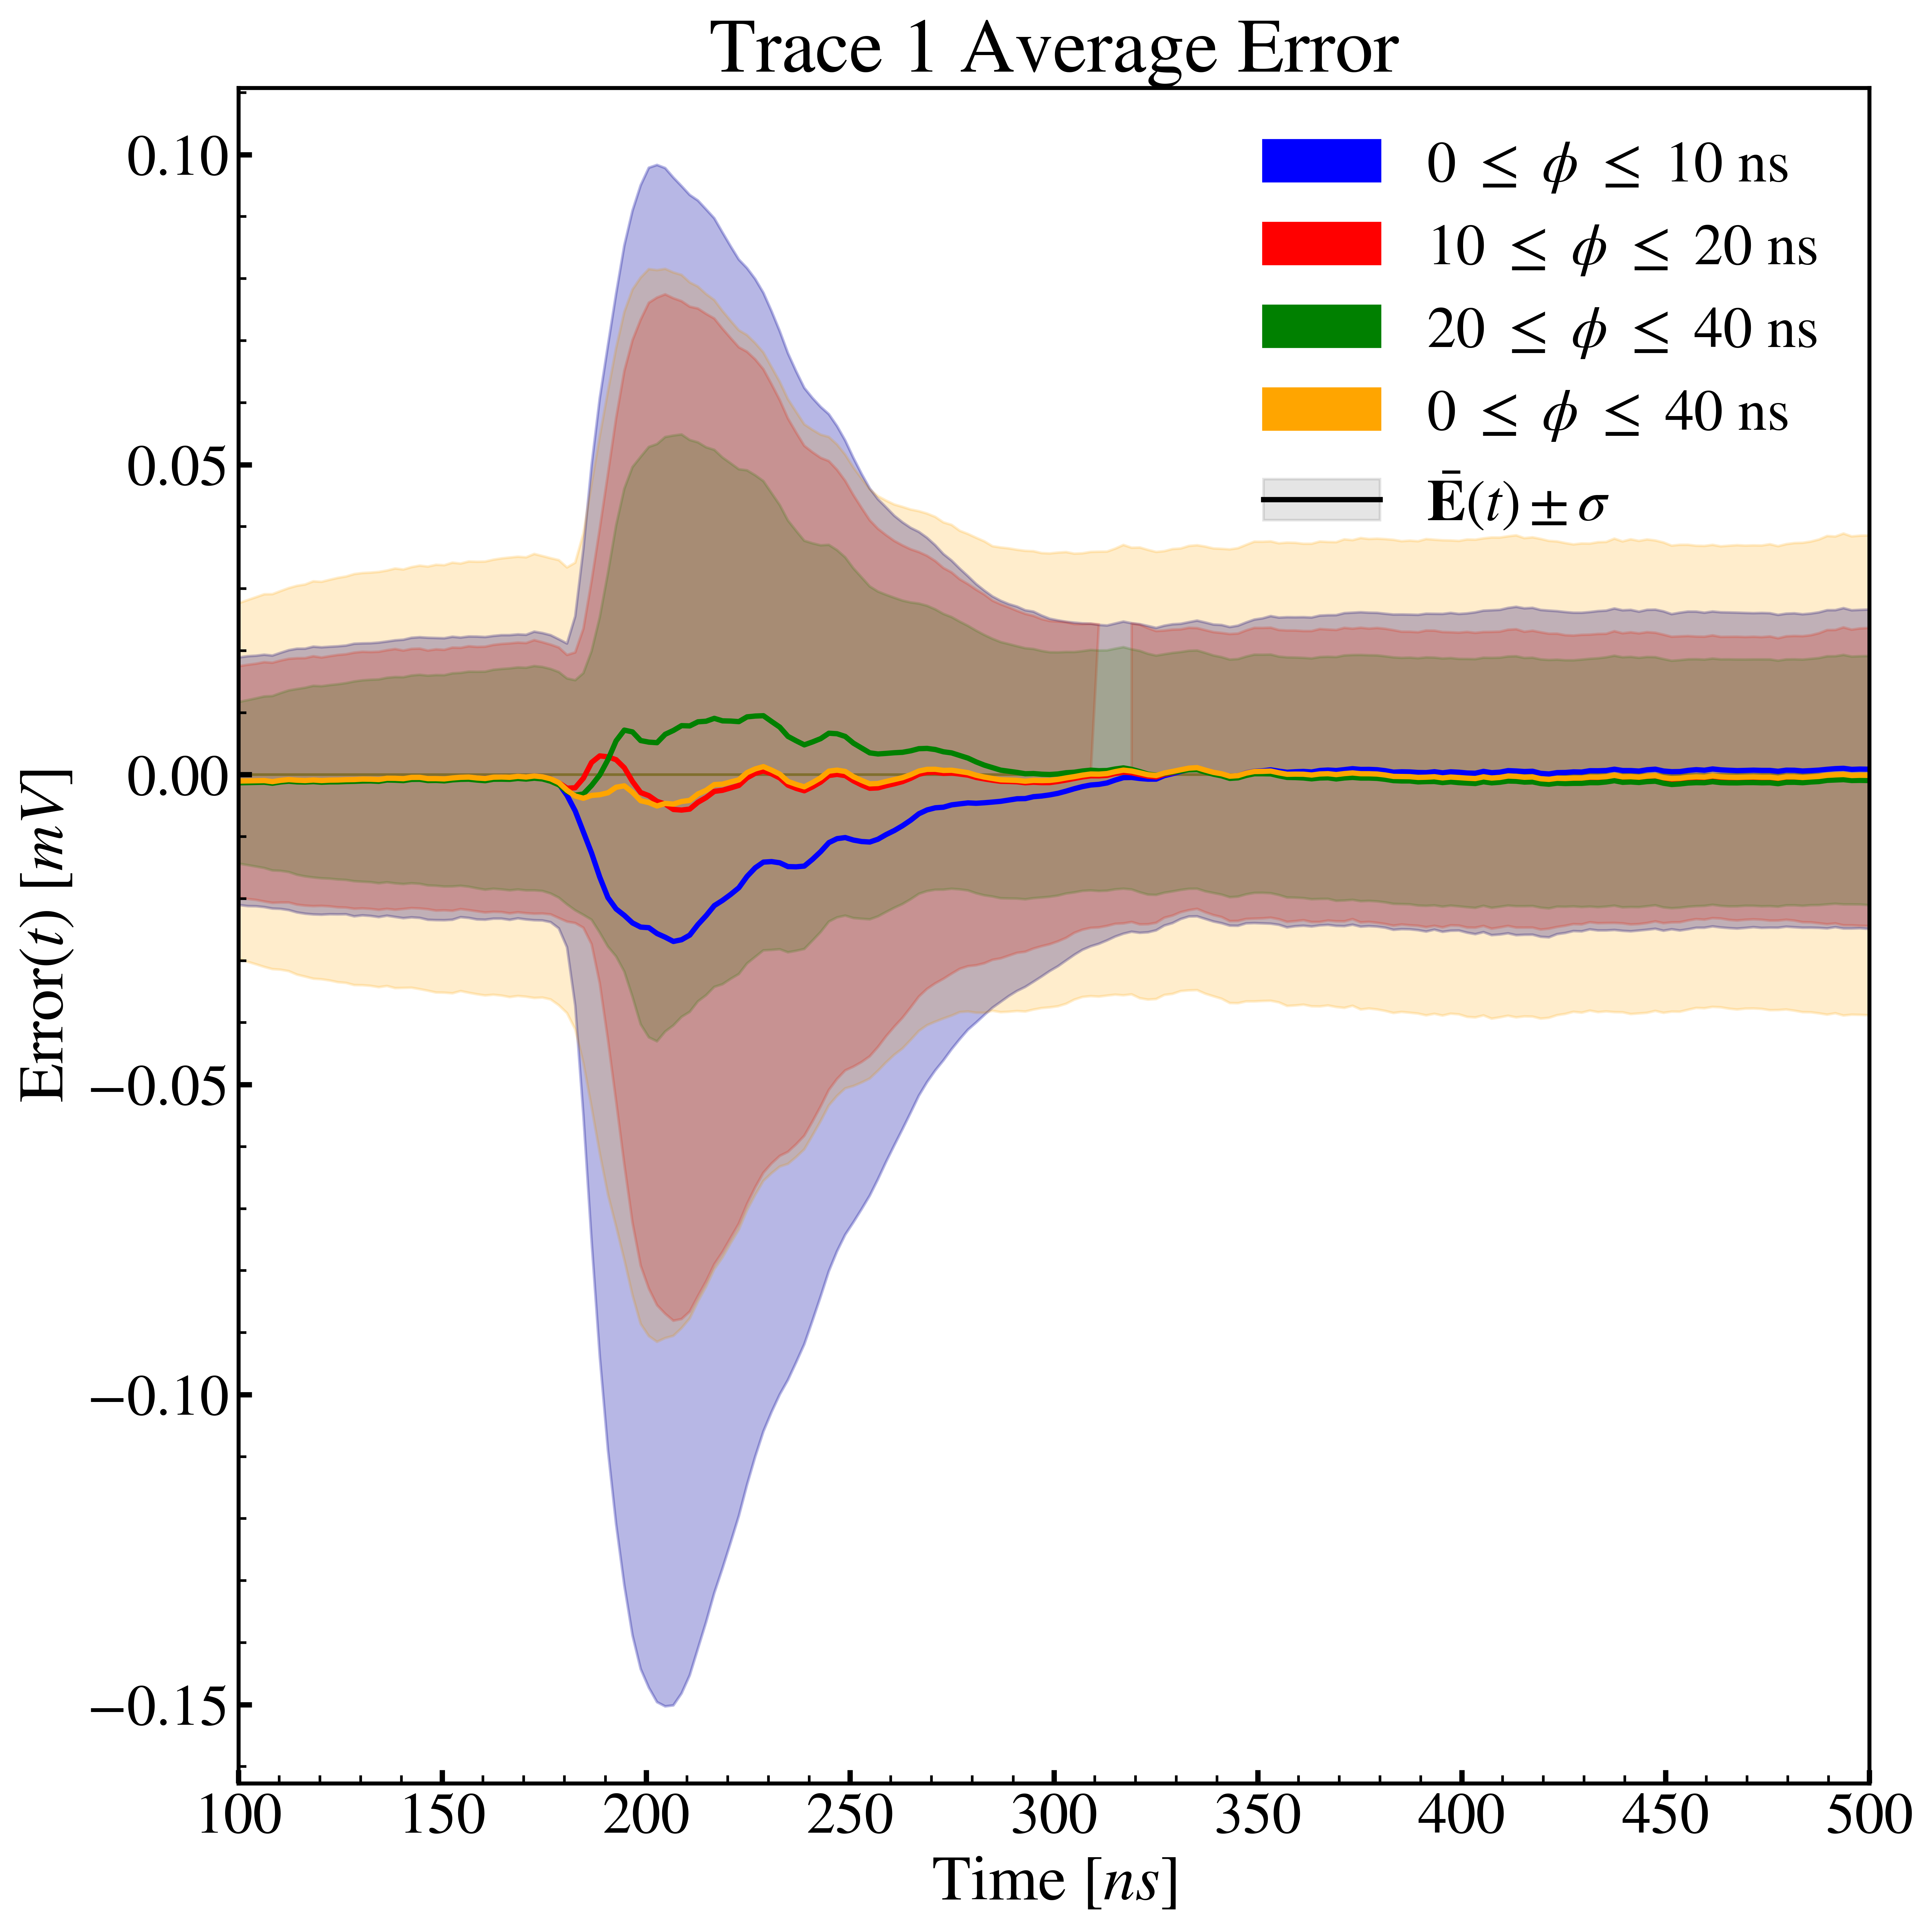

In [103]:
fig = plt.figure(figsize=(10, 10), dpi=600, constrained_layout=True)
ax = plt.subplot(111)
t = np.linspace(0,600,300)
ax.plot(t,results['phase_shift_0to10ns']['average_res_trace2'], label=r'0 $\leq$ $\phi$ $\leq$ 10 ns', color='blue')
ax.plot(t,results['phase_shift_10to20ns']['average_res_trace2'], label=r'10 $\leq$ $\phi$ $\leq$ 20 ns', color='red')
ax.plot(t,results['phase_shift_20to40ns']['average_res_trace2'], label=r'20 $\leq$ $\phi$ $\leq$ 40 ns', color='green')
ax.plot(t,results['phase_shift_0to40ns']['average_res_trace2'], label=r'0 $\leq$ $\phi$ $\leq$ 40 ns', color='orange')

ax.fill_between(t, results['phase_shift_0to10ns']['average_res_trace2'] + results['phase_shift_0to10ns']['std_res_trace2'],
                results['phase_shift_0to10ns']['average_res_trace2'] - results['phase_shift_0to10ns']['std_res_trace2'],
                color='blue', alpha=0.2, interpolate=True)

ax.fill_between(t, results['phase_shift_10to20ns']['average_res_trace2'] - results['phase_shift_10to20ns']['std_res_trace2'],
                where=results['phase_shift_10to20ns']['average_res_trace2'] - results['phase_shift_10to20ns']['std_res_trace2'] >= results['phase_shift_0to10ns']['average_res_trace2'] - results['phase_shift_0to10ns']['std_res_trace2'],
                color='red', alpha=0.2, interpolate=True)
ax.fill_between(t, results['phase_shift_10to20ns']['average_res_trace2'] + results['phase_shift_10to20ns']['std_res_trace2'],
                where=results['phase_shift_10to20ns']['average_res_trace2'] + results['phase_shift_10to20ns']['std_res_trace2'] <= results['phase_shift_0to10ns']['average_res_trace2'] + results['phase_shift_0to10ns']['std_res_trace2'],
                color='red', alpha=0.2, interpolate=True)

ax.fill_between(t, results['phase_shift_20to40ns']['average_res_trace2'] - results['phase_shift_20to40ns']['std_res_trace2'],
                where=results['phase_shift_20to40ns']['average_res_trace2'] - results['phase_shift_20to40ns']['std_res_trace2'] >= results['phase_shift_0to10ns']['average_res_trace2'] - results['phase_shift_0to10ns']['std_res_trace2'],
                color='green', alpha=0.2, interpolate=True)
ax.fill_between(t, results['phase_shift_20to40ns']['average_res_trace2'] + results['phase_shift_20to40ns']['std_res_trace2'],
                where=results['phase_shift_20to40ns']['average_res_trace2'] + results['phase_shift_20to40ns']['std_res_trace2'] <= results['phase_shift_0to10ns']['average_res_trace2'] + results['phase_shift_0to10ns']['std_res_trace2'],
                color='green', alpha=0.2, interpolate=True)
                
ax.fill_between(t, results['phase_shift_0to40ns']['average_res_trace2'] - results['phase_shift_0to40ns']['std_res_trace2'],
                results['phase_shift_0to40ns']['average_res_trace2'] + results['phase_shift_0to40ns']['std_res_trace2'],
                color='orange', alpha=0.2, interpolate=True)

ax.set_xlabel(r'Time $[ns]$')
ax.set_ylabel(r'$\mathrm{Error}(t)$ $[mV]$')
ax.set_xlim(100,500)

import matplotlib.patches as mpatches
ax.legend(loc='best',frameon=False,
          handles=[mpatches.Patch(color='blue'), mpatches.Patch(color='red'), mpatches.Patch(color='green'),mpatches.Patch(color='orange'),
                   (ax.plot([],[],linestyle="-", color='black')[0],
                    ax.fill_between(t, results['phase_shift_0to10ns']['average_res_trace2'] + results['phase_shift_0to10ns']['std_res_trace2'],
                                    results['phase_shift_0to10ns']['average_res_trace2'] - results['phase_shift_0to10ns']['std_res_trace2'],
                                    color='black', alpha=0.1, interpolate=True)),
                    ],
          labels=[r'0 $\leq$ $\phi$ $\leq$ 10 ns', r'10 $\leq$ $\phi$ $\leq$ 20 ns', r'20 $\leq$ $\phi$ $\leq$ 40 ns', r'0 $\leq$ $\phi$ $\leq$ 40 ns',r'$\bar{\mathrm{\mathbf{E}}}(t) \pm \sigma$'])
ax.set_title("Trace 1 Average Error")
plt.show()
fig.savefig('/content/drive/MyDrive/DeepLearningFinalProject/Trace2Res.png', bbox_inches='tight')

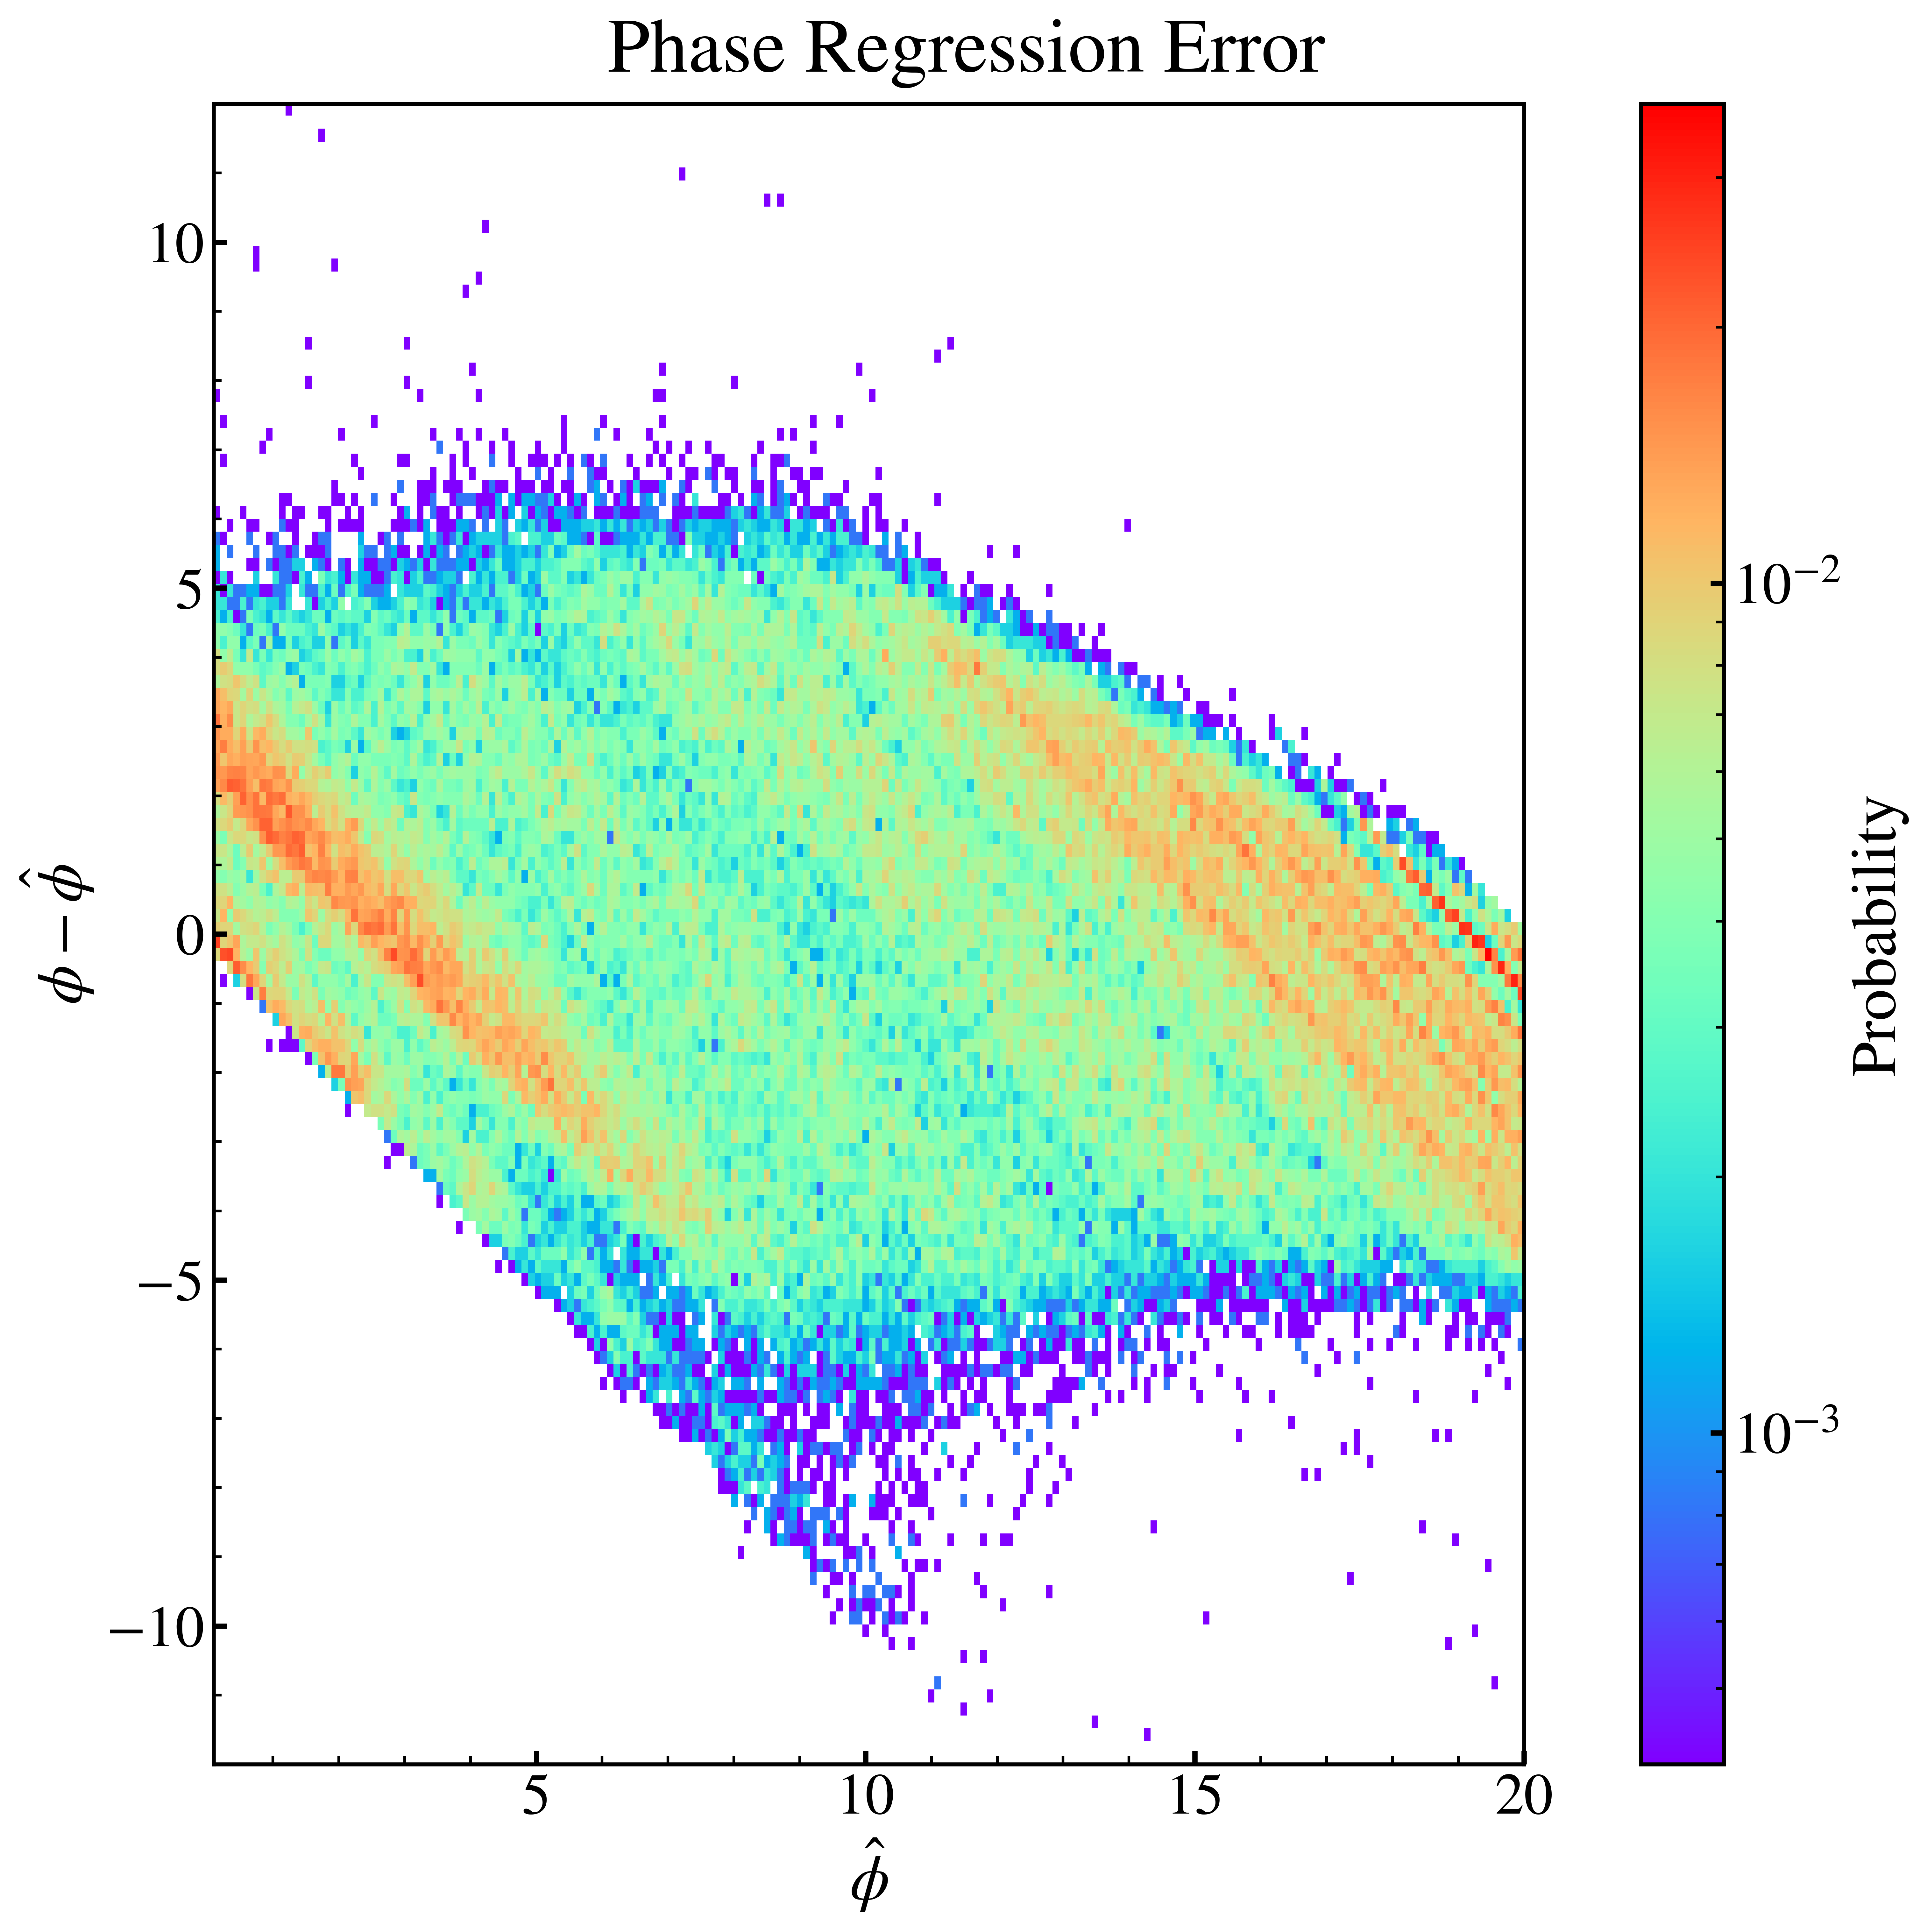

In [104]:
fig = plt.figure(figsize=(10, 10), dpi=600,constrained_layout=True)
ax = plt.subplot(111)
hist = ax.hist2d(results['phase_shift_0to40ns']['y_phase'][:,0],results['phase_shift_0to40ns']['res_phase'][:,0], bins=200,
          label=r'0 $\leq$ $\phi$ $\leq$ 40 ns',  cmap='rainbow', norm=colors.LogNorm(),
          density=True,
          range=[[0.1,20],[np.min(results['phase_shift_0to40ns']['res_phase']),np.max(results['phase_shift_0to40ns']['res_phase'])]])
cbar = plt.colorbar(hist[3])
cbar.set_label('Probability')
ax.set_xlabel(r'$\hat{\phi}$')
ax.set_ylabel(r'$\phi - \hat{\phi}$')
ax.set_xlim(0.1,20)
ax.set_ylim(-12,12)



fig.suptitle(r'Phase Regression Error')

plt.show()
fig.savefig('/content/drive/MyDrive/DeepLearningFinalProject/PhaseRes.png', bbox_inches='tight')

<ipython-input-105-e1c32294bd0d>:7: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="best",frameon=False)


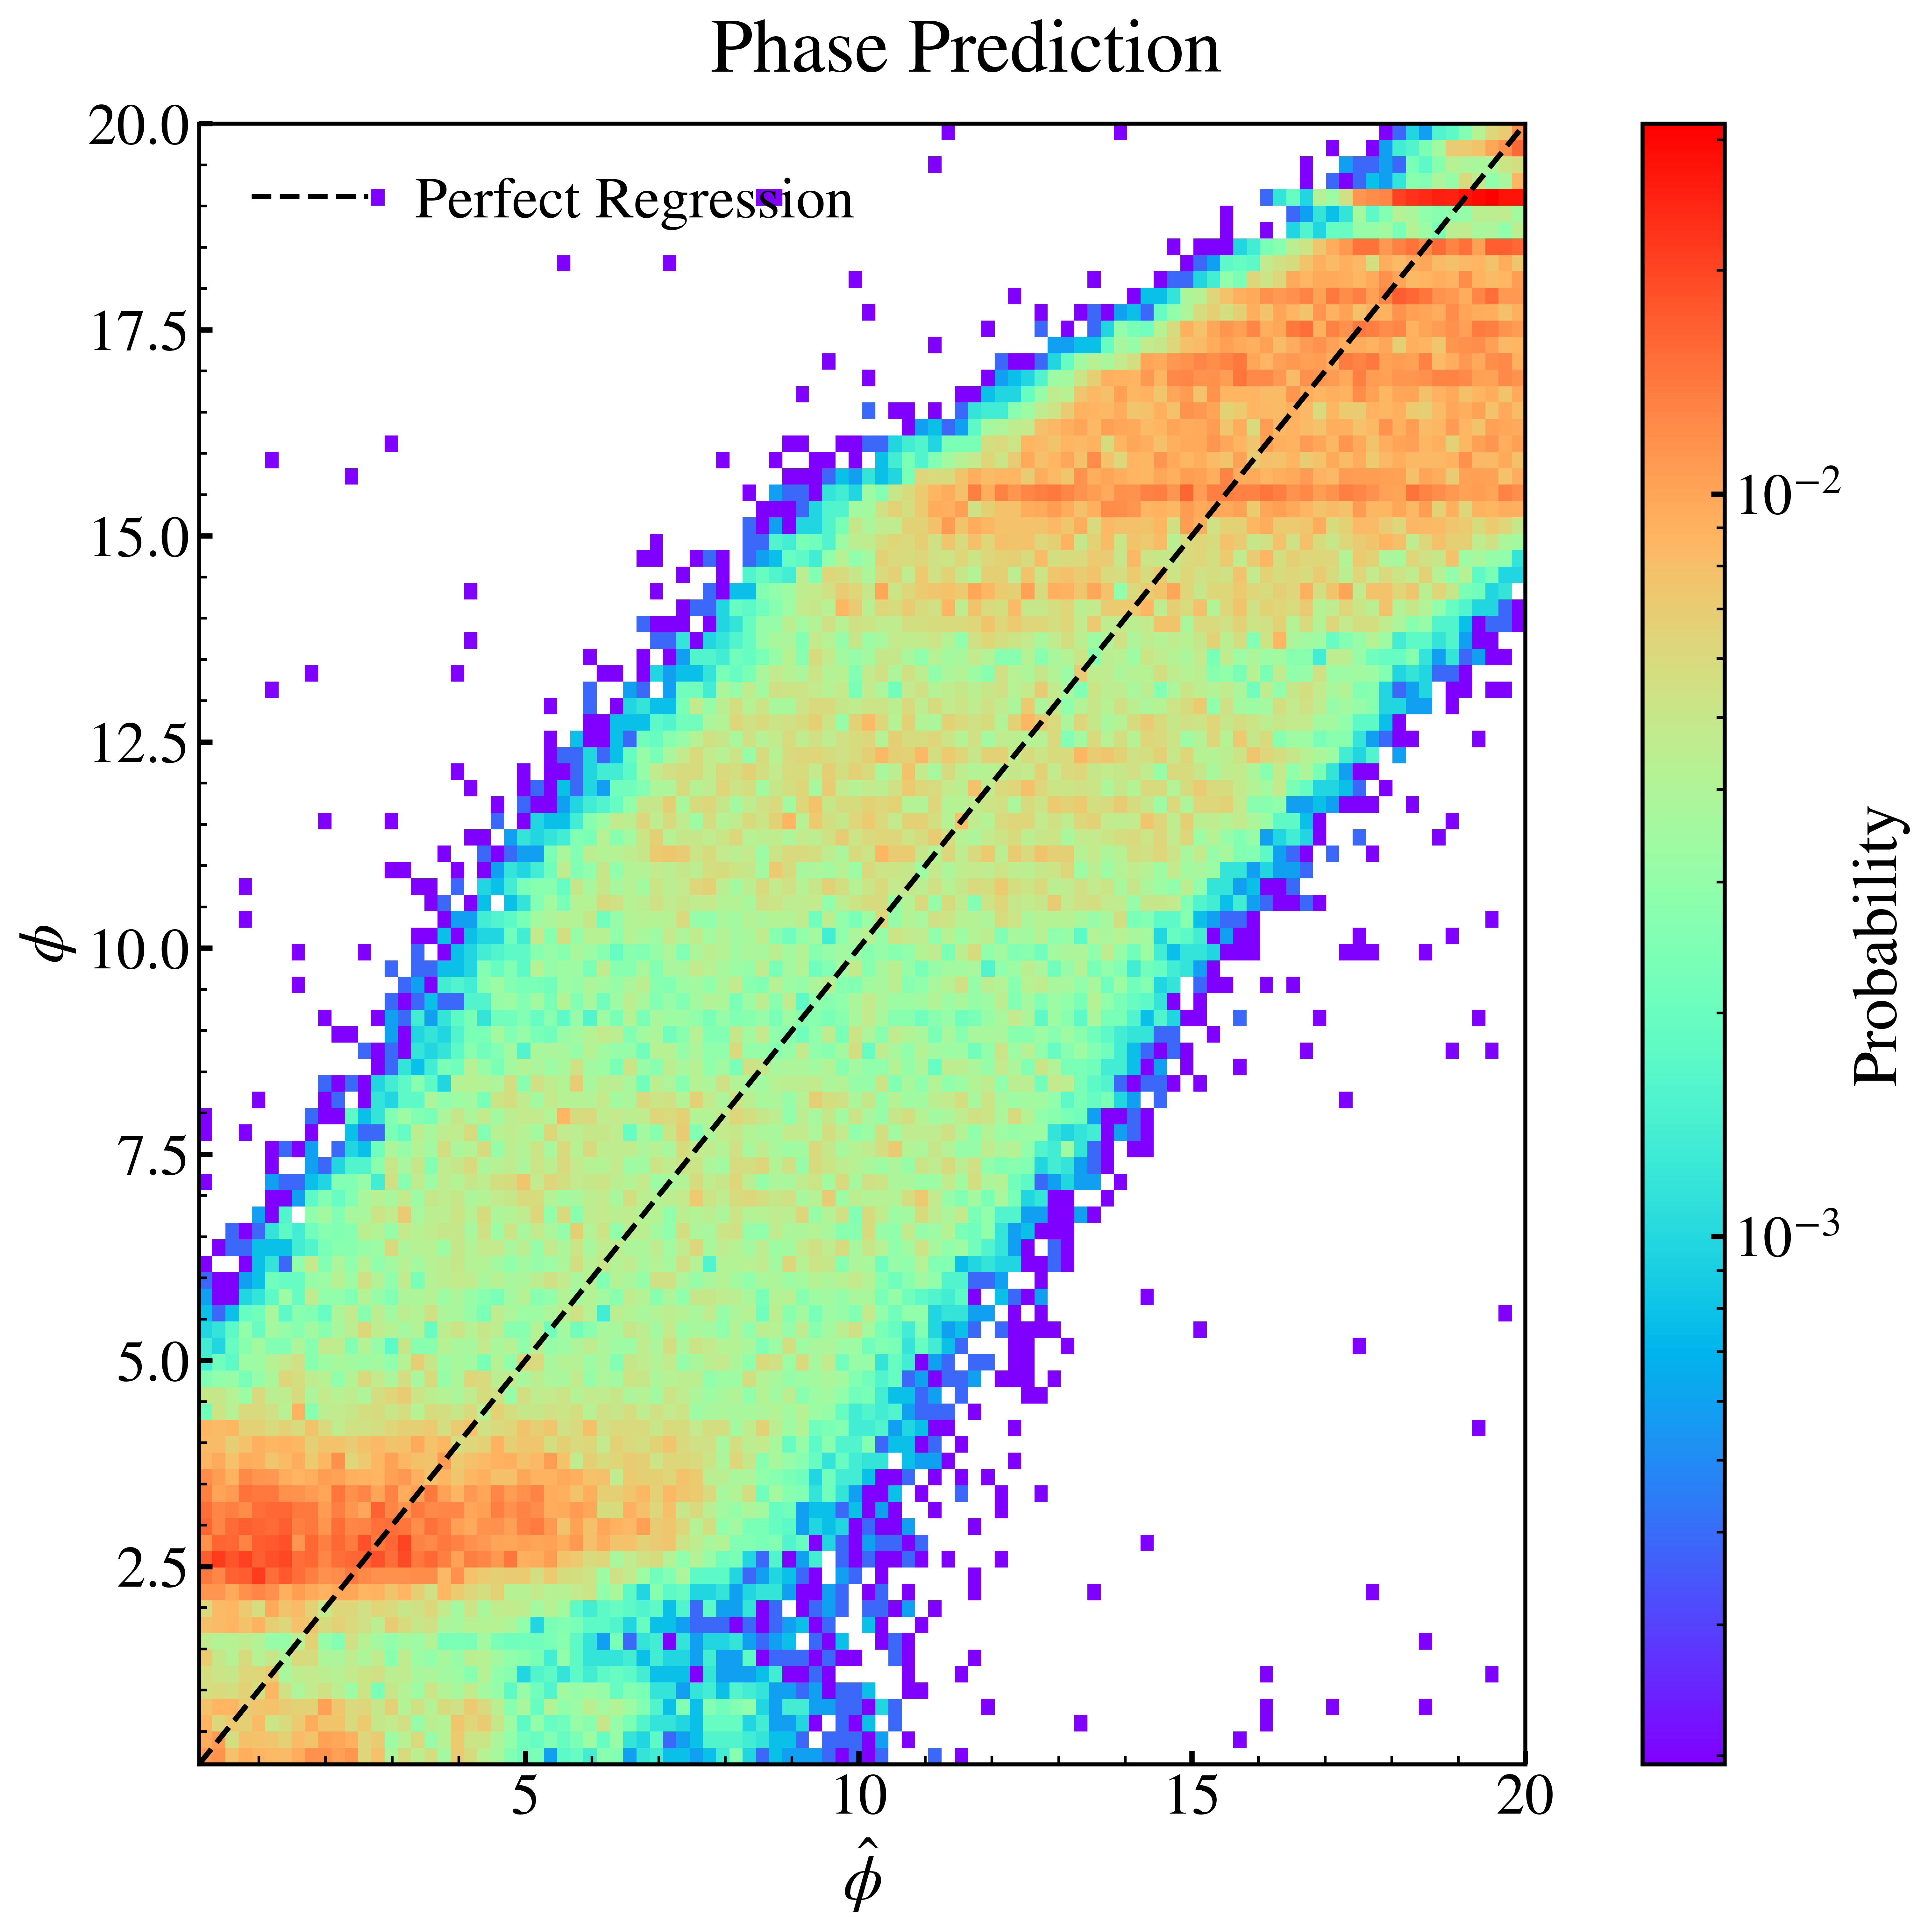

In [105]:
fig = plt.figure(figsize=(10, 10), dpi=600,constrained_layout=True)
ax = plt.subplot(111)
import matplotlib.colors as colors
hist = ax.hist2d(results['phase_shift_0to40ns']['y_phase'][:,0],results['phase_shift_0to40ns']['pred_phase'][:,0], bins=100, label=r'0 $\leq$ $\phi$ $\leq$ 40 ns', cmap='rainbow', norm=colors.LogNorm(), range=[[0.1,20], [0.1,20]], density=True)
cbar = plt.colorbar(hist[3])
ax.plot([0.1,20],[0.1,20], linestyle="--",label="Perfect Regression",color="black",linewidth=2.0)
ax.legend(loc="best",frameon=False)
cbar.set_label('Probability')
ax.set_xlabel(r'$\hat{\phi}$')
ax.set_ylabel(r'$\phi$')
ax.set_xlim(0.1,20)
ax.set_ylim(0.1,20)



fig.suptitle(r'Phase Prediction')
fig.savefig('/content/drive/MyDrive/DeepLearningFinalProject/PhasePredVsTruth.png', bbox_inches='tight')
plt.show()

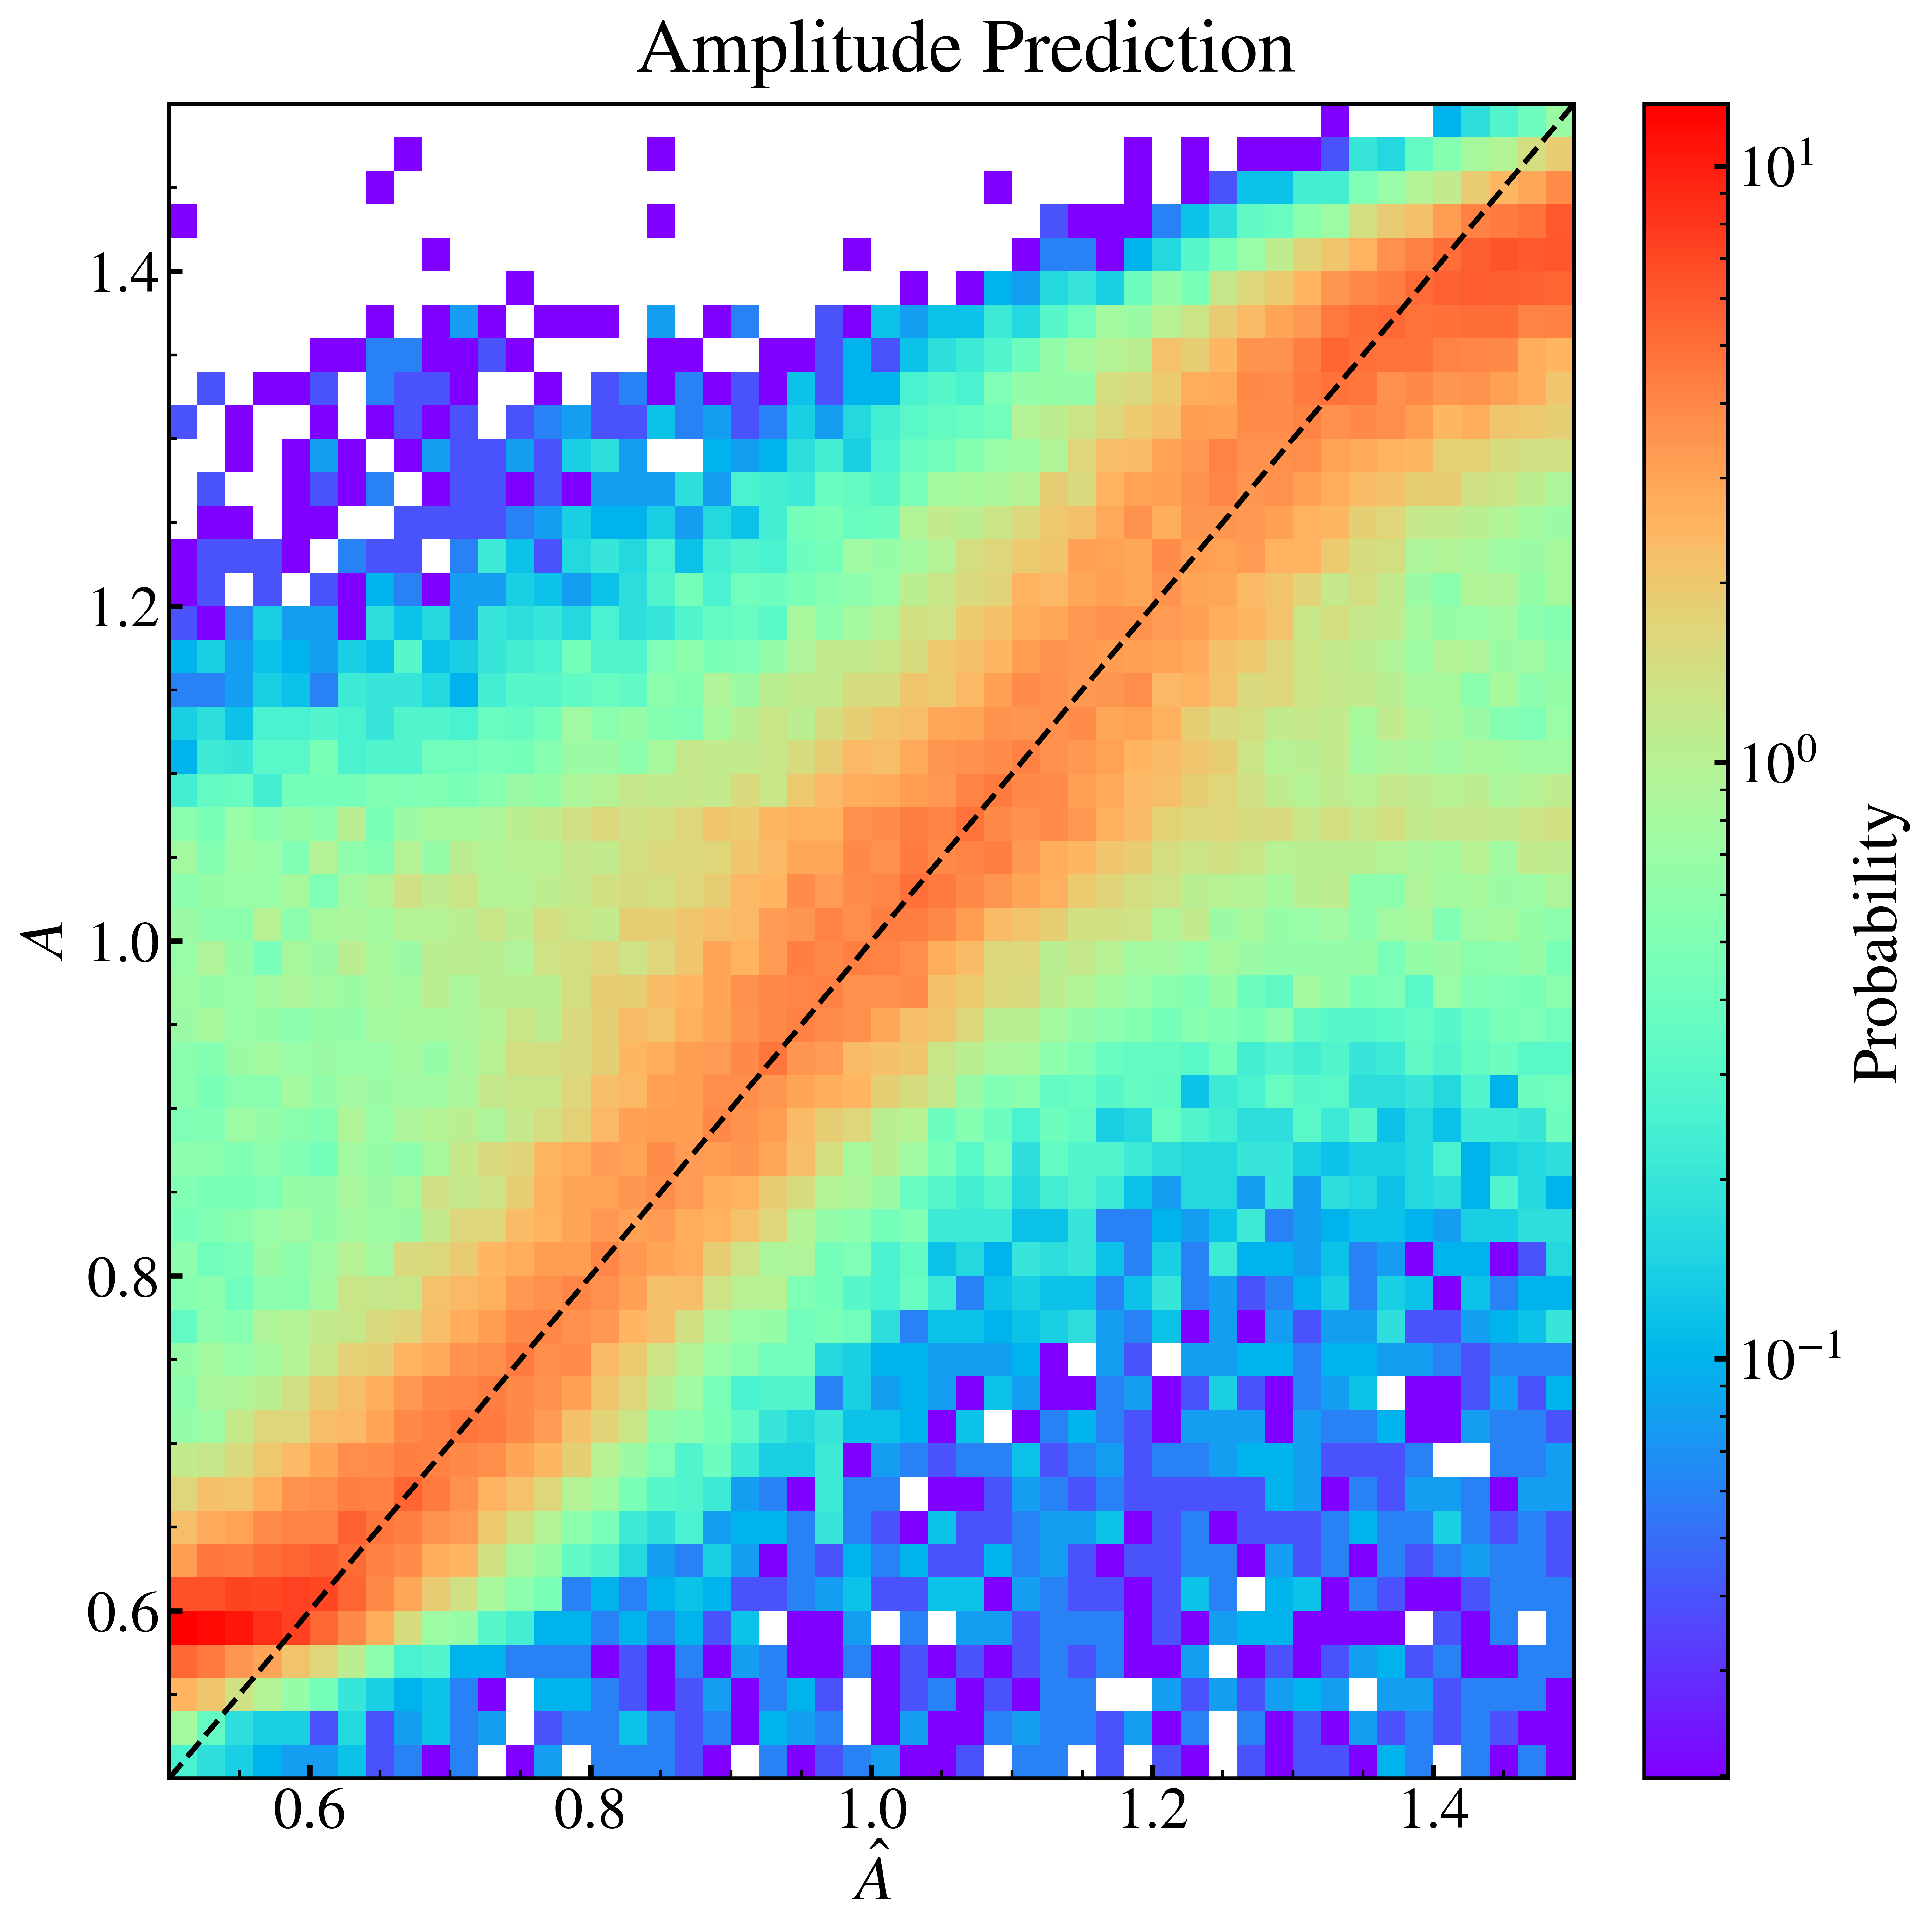

In [106]:
fig = plt.figure(figsize=(10, 10), dpi=600,constrained_layout=True)
ax = plt.subplot(111)
import matplotlib.colors as colors
hist = ax.hist2d(results['phase_shift_0to40ns']['y_amp'][:,0],results['phase_shift_0to40ns']['pred_amp'][:,0], bins=50, label=r'0 $\leq$ $\phi$ $\leq$ 40 ns', cmap='rainbow', norm=colors.LogNorm(),
                 range=[[0.5,1.5], [0.5,1.5]], density=True)
cbar = plt.colorbar(hist[3])
ax.plot([0.5,1.5],[0.5,1.5], linestyle="--",label="Perfect Regression",color="black",linewidth=2.0)
# ax.legend(loc="best",frameon=False)
cbar.set_label('Probability')
ax.set_xlabel(r'$\hat{A}$')
ax.set_ylabel(r'$A$')
# ax.set_xlim(0.1,20)
# ax.set_ylim(0.1,20)



fig.suptitle(r'Amplitude Prediction')
fig.savefig('/content/drive/MyDrive/DeepLearningFinalProject/AmpPredVsTruth.png', bbox_inches='tight')

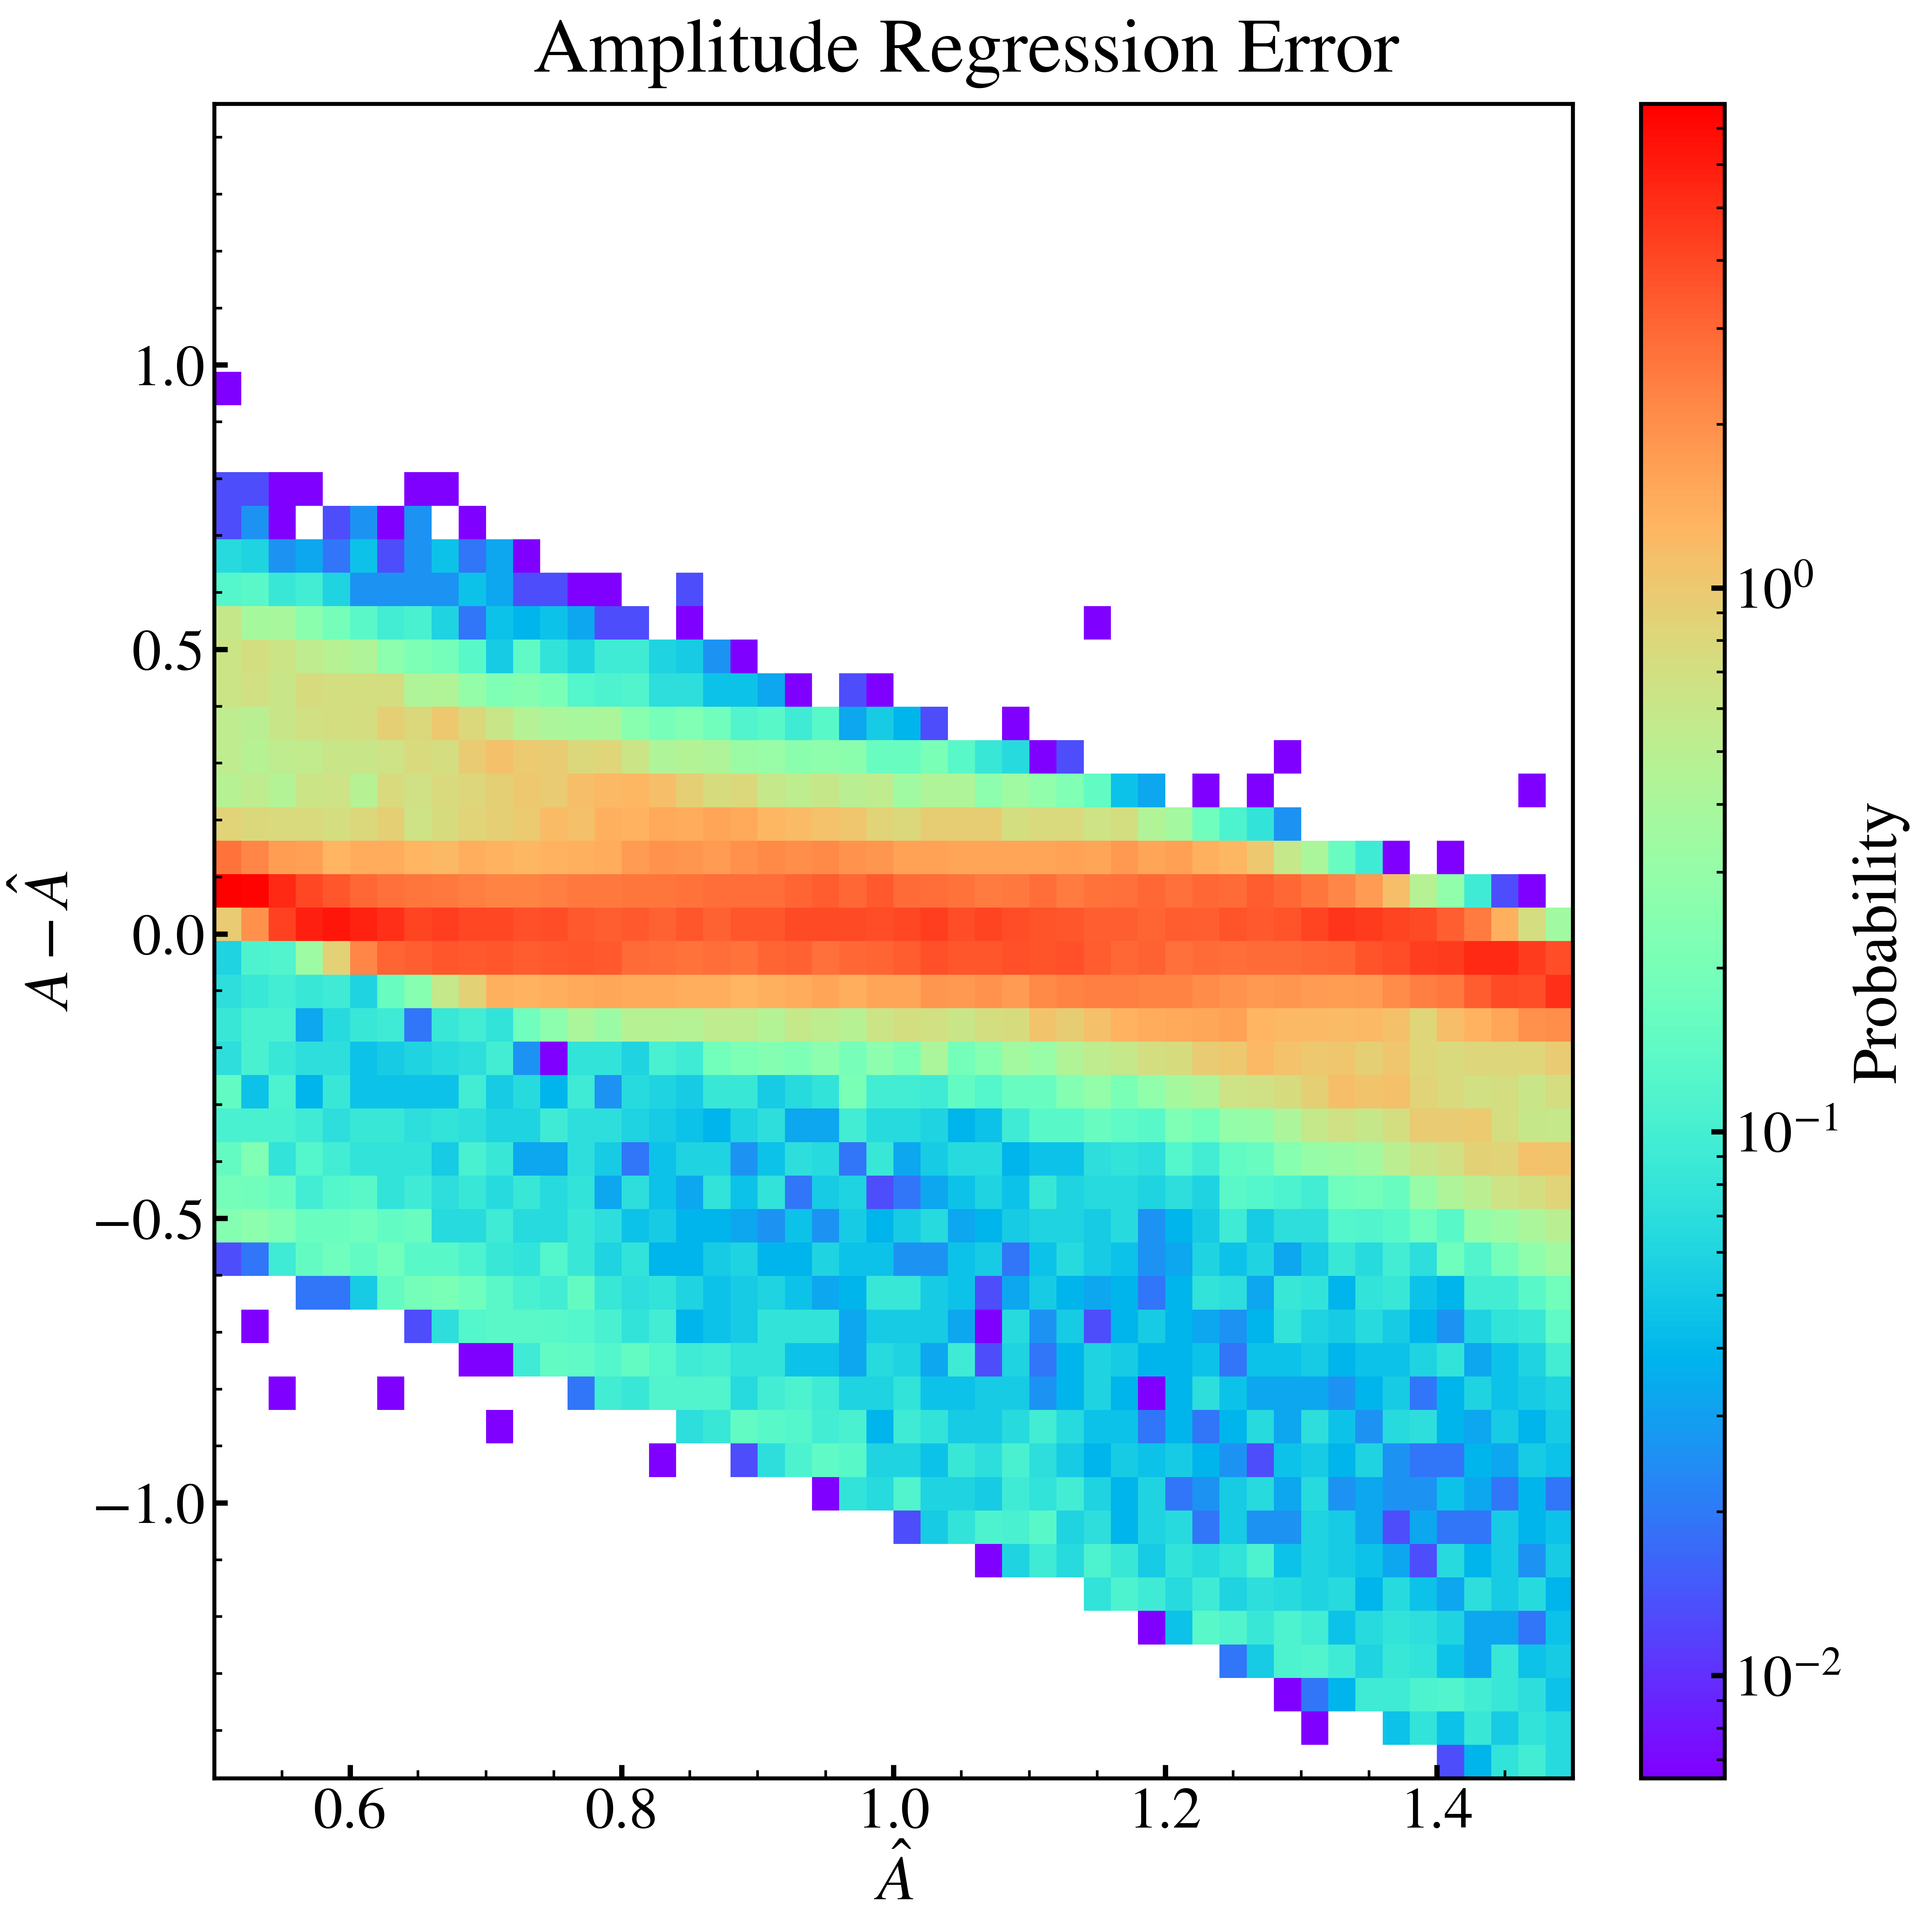

In [107]:
fig = plt.figure(figsize=(10, 10), dpi=600,constrained_layout=True)
ax = plt.subplot(111)
hist = ax.hist2d(results['phase_shift_0to40ns']['y_amp'][:,0],results['phase_shift_0to40ns']['res_amp'][:,0], bins=50,
          label=r'0 $\leq$ $\phi$ $\leq$ 40 ns',  cmap='rainbow', norm=colors.LogNorm(),
          density=True,
          range=[[0.5,1.5],[np.min(results['phase_shift_0to40ns']['res_amp']),np.max(results['phase_shift_0to40ns']['res_amp'])]])
cbar = plt.colorbar(hist[3])
cbar.set_label('Probability')
ax.set_xlabel(r'$\hat{A}$')
ax.set_ylabel(r'$A - \hat{A}$')
ax.set_xlim(0.5,1.5)
# ax.set_ylim(-12,12)



fig.suptitle(r'Amplitude Regression Error')

plt.show()
fig.savefig('/content/drive/MyDrive/DeepLearningFinalProject/AmpRes.png', bbox_inches='tight')

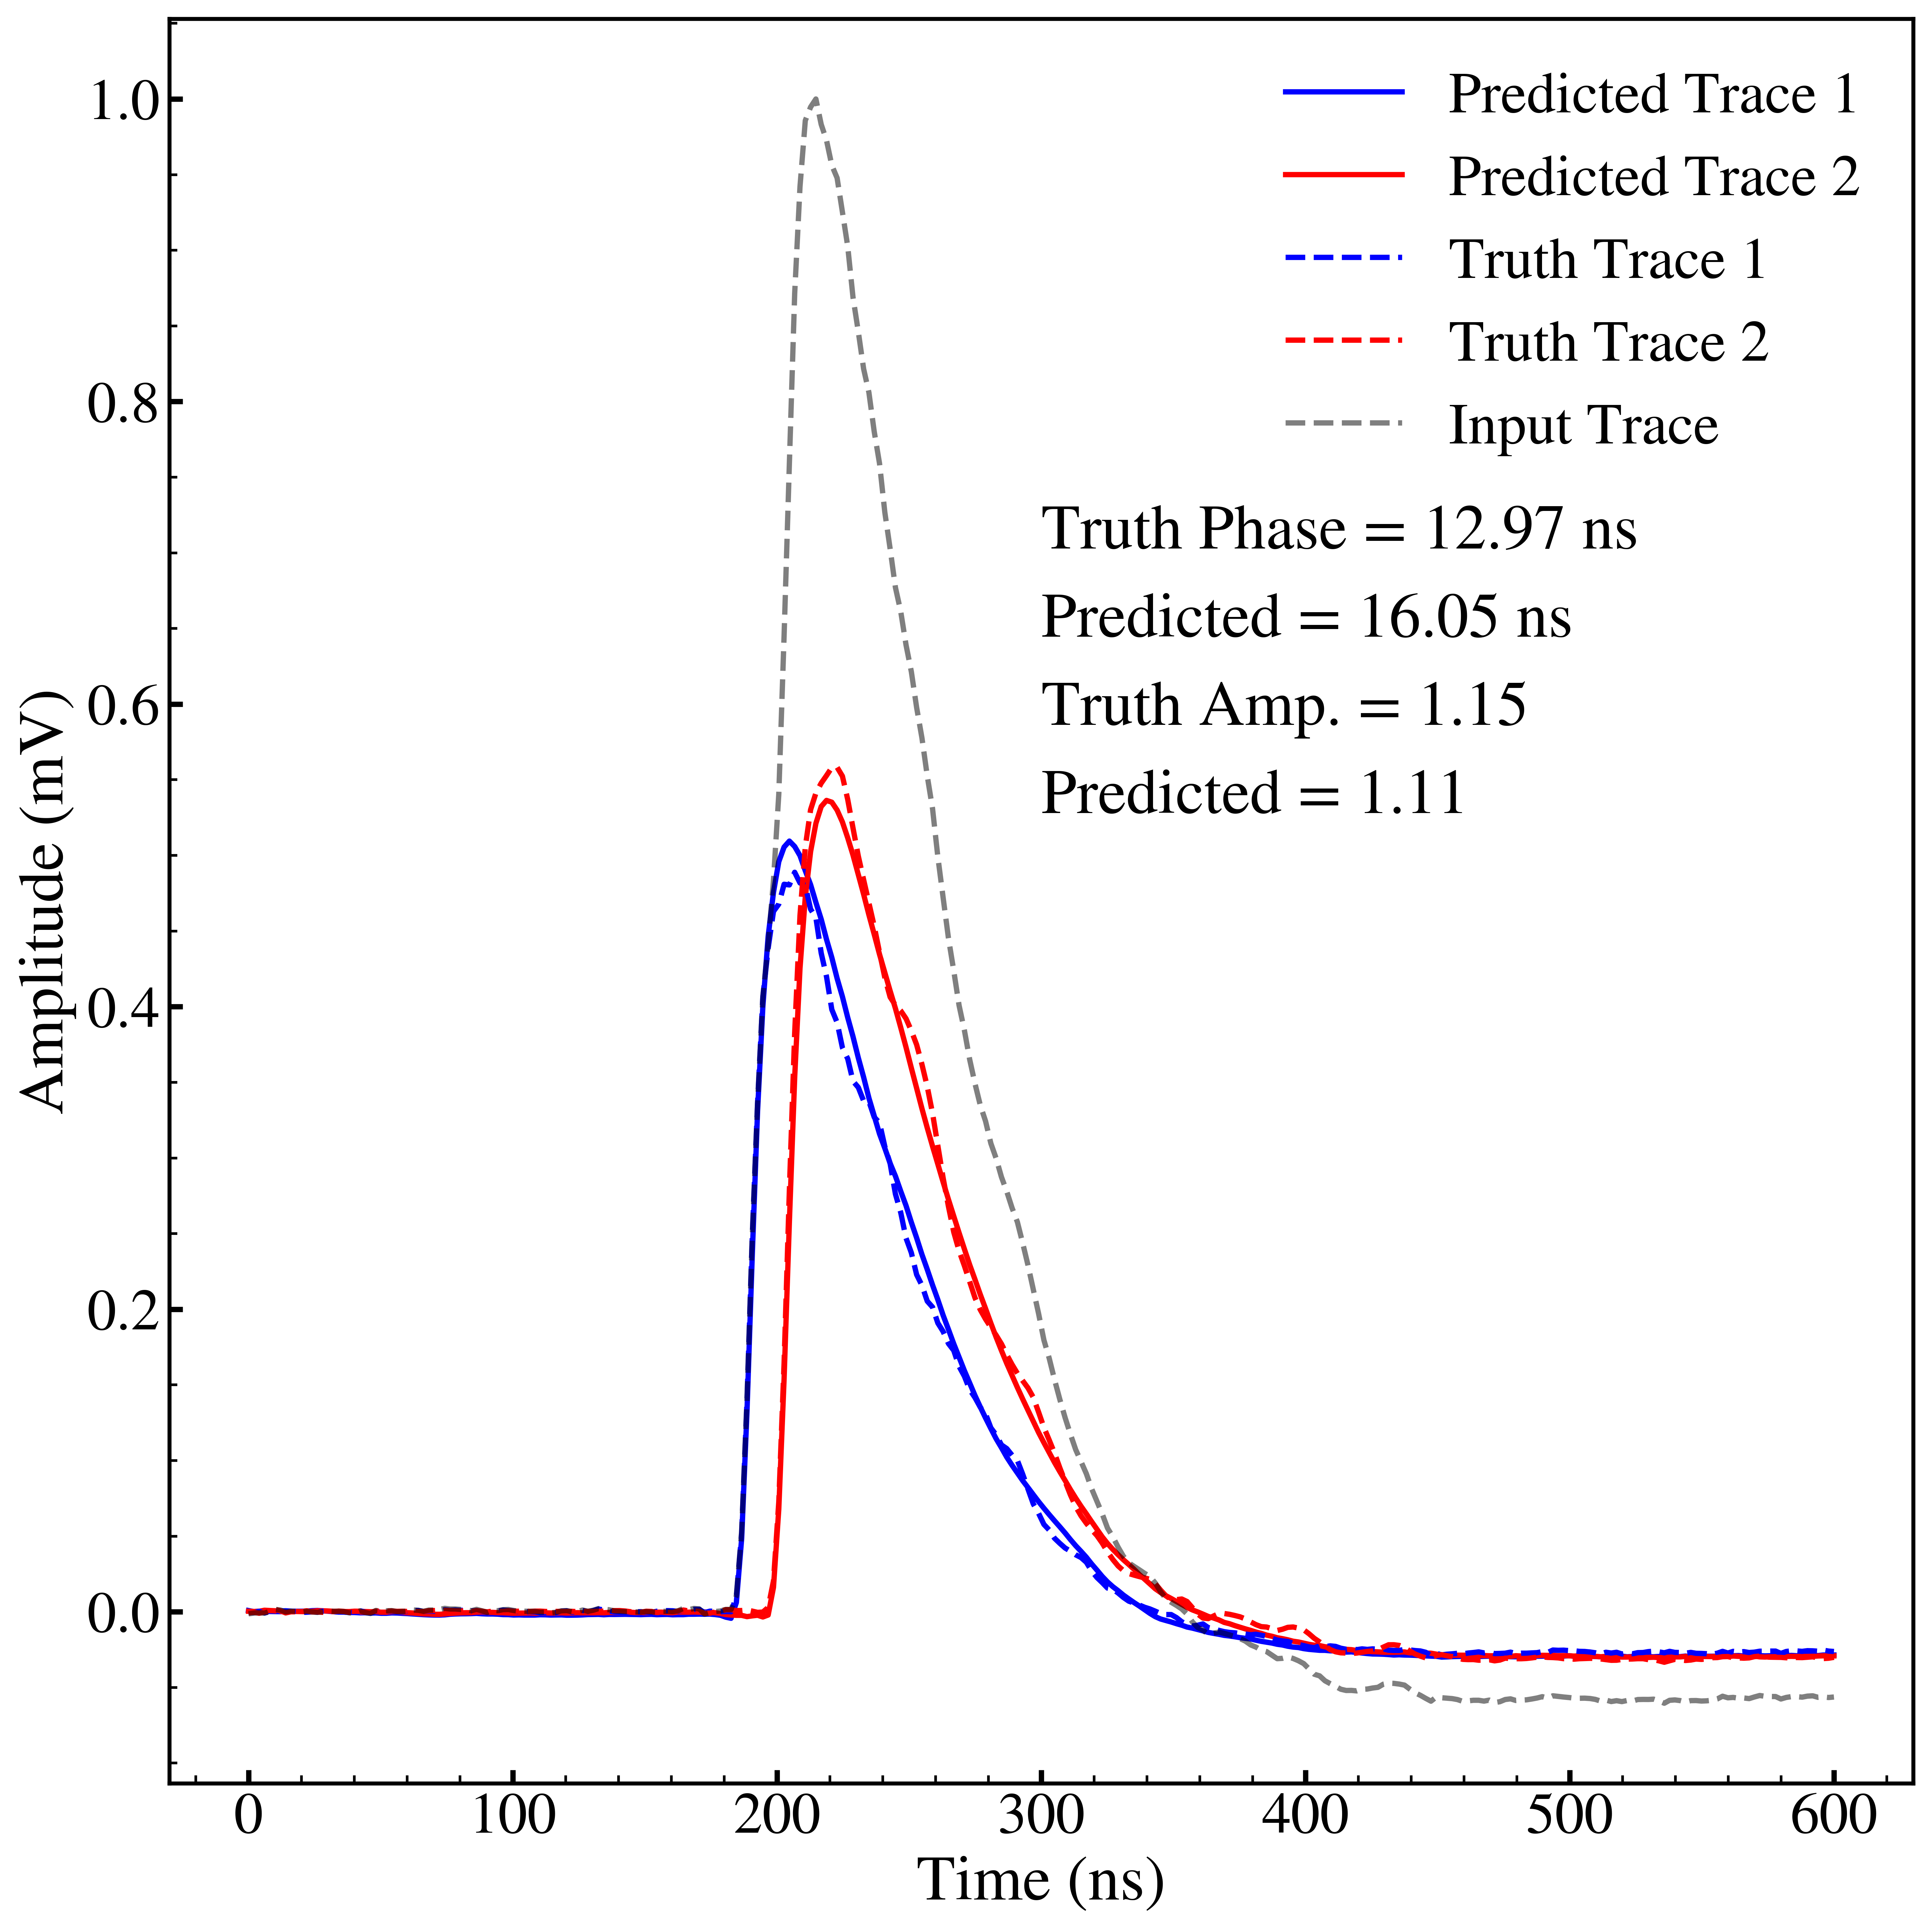

In [127]:
fig=plt.figure(figsize=(10,10), dpi=600, constrained_layout=True)
ax = plt.subplot(111)
n = np.random.randint(0, results['phase_shift_0to40ns']['pred_trace'].shape[0])
t = np.linspace(0, 600, 300)

ax.plot(t, results['phase_shift_0to40ns']['pred_trace'][n][0], label='Predicted Trace 1', color='blue')
ax.plot(t, results['phase_shift_0to40ns']['pred_trace'][n][1], label='Predicted Trace 2', color='red')
ax.plot(t, results['phase_shift_0to40ns']['y_trace'][n][0], label='Truth Trace 1', color='blue', linestyle='--')
ax.plot(t, results['phase_shift_0to40ns']['y_trace'][n][1], label='Truth Trace 2', color='red', linestyle='--')
ax.plot(t, results['phase_shift_0to40ns']['x_trace'][n], label='Input Trace', color='black',alpha=0.5, linestyle='--')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Amplitude (mV)')
ax.legend(loc='upper right')
ax.text(0.5,0.7, f'Truth Phase = {results["phase_shift_0to40ns"]["y_phase"][n][0]:.2f} ns' ,transform=ax.transAxes)
ax.text(0.5,0.65, f'Predicted = {results["phase_shift_0to40ns"]["pred_phase"][n][0]:.2f} ns', transform=ax.transAxes)
ax.text(0.5,0.6, f'Truth Amp. = {results["phase_shift_0to40ns"]["y_amp"][n][0]:.2f}', transform=ax.transAxes)
ax.text(0.5,0.55, f'Predicted = {results["phase_shift_0to40ns"]["pred_amp"][n][0]:.2f}', transform=ax.transAxes)


import matplotlib.patches as mpatches
ax.legend(loc="best",frameon=False)


plt.show()
fig.savefig('/content/drive/MyDrive/DeepLearningFinalProject/TraceExample.png', bbox_inches='tight')
